In [1]:
import numpy as np
import pandas as pd
import re
import time
import torch
import torch.nn as nn
import wandb
import random
import math
import itertools
from transformers import BertTokenizer, BertModel, BertConfig, BertForSequenceClassification, BertPreTrainedModel, Trainer, TrainingArguments
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, accuracy_score, precision_recall_fscore_support, f1_score, classification_report
from kaggle_secrets import UserSecretsClient

In [2]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("wandb-key")

wandb.login(key=secret_value_0)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: nicost918 (nicost918-petra-christian-university). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [3]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

In [4]:
data = pd.read_csv('/kaggle/input/doctors-answer-dataset/Indo-Online Health Consultation-Medical Interview-Clean.csv', encoding='latin-1')
data.head()

,No,answer,1-FR,2-GI,3-PI,4-DM,5-EDTRB,6-RE,Text_Clean,filtered_text,token,tokens_stemmed,Process_Data
0,1,"Halo Rizal,Radang tenggorokan umunya disebabka...",1,0,1,1,1,0,halo rizal radang tenggorokan umunya disebabka...,halo rizal radang tenggorokan umunya disebabka...,"['halo', 'rizal', 'radang', 'tenggorokan', 'um...","['halo', 'rizal', 'radang', 'tenggorok', 'umu'...",halo rizal radang tenggorok umu sebab infeksi ...
1,2,"Halo Hellas,Cacar air merupakan suatu penyakit...",1,0,1,1,1,0,halo hellas cacar air merupakan suatu penyakit...,halo hellas cacar air penyakit disebabkan viru...,"['halo', 'hellas', 'cacar', 'air', 'penyakit',...","['halo', 'hellas', 'cacar', 'air', 'sakit', 's...",halo hellas cacar air sakit sebab virus varise...
2,3,Halo Rory.......Terimakasih atas pertanyaan An...,1,0,1,1,1,0,halo rory terimakasih atas pertanyaan anda per...,halo rory terimakasih ketahui gangguan kulit s...,"['halo', 'rory', 'terimakasih', 'ketahui', 'ga...","['halo', 'rory', 'terimakasih', 'tahu', 'gangg...",halo rory terimakasih tahu ganggu kulit rangka...
3,4,"Alo AfriYani, Terimakasih atas pertanyaannya. ...",1,0,1,1,1,0,alo afriyani terimakasih atas pertanyaannya ku...,alo afriyani terimakasih pertanyaannya kuku ja...,"['alo', 'afriyani', 'terimakasih', 'pertanyaan...","['alo', 'afriyani', 'terimakasih', 'tanya', 'k...",alo afriyani terimakasih tanya kuku jari kaki ...
4,5,"Halo,Telinga berdenging atau tinitus merupak...",1,0,1,1,1,0,halo telinga berdenging atau tinitus merupakan...,halo telinga berdenging tinitus sensasi penden...,"['halo', 'telinga', 'berdenging', 'tinitus', '...","['halo', 'telinga', 'denging', 'tinitus', 'sen...",halo telinga denging tinitus sensasi dengar de...


In [5]:
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)

labels = data.columns[2:8]
# Extract features and labels for training and validation
X_train = train_data['Text_Clean'].values
y_train = train_data[labels].values
X_val = val_data['Text_Clean'].values
y_val = val_data[labels].values

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(400,) (400, 6)
(100,) (100, 6)


In [6]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset
import numpy as np
import torch

# Define custom Dataset class
class DoctorAnswerDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=256, use_float=True):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        labels = self.labels[idx]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['labels'] = torch.tensor(labels, dtype=torch.float)
        return item

# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p2')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [7]:
# Define compute metrics for evaluation
def compute_metrics(p):
    preds = torch.sigmoid(torch.tensor(p.predictions)).round()  # Sigmoid and threshold for multi-label
    labels = torch.tensor(p.label_ids)
    
    accuracy = accuracy_score(labels, preds)

    # Standard multi-label precision, recall, and F1 metrics
    precision, recall, f1_micro, _ = precision_recall_fscore_support(labels, preds, average='micro', zero_division=0)
    a, b, f1_macro, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro
    }

In [8]:
# Define compute metrics for evaluation
def compute_metrics_eval(p):
    result = compute_metrics(p)
    
    preds = torch.sigmoid(torch.tensor(p.predictions)).round()  # Sigmoid and threshold for multi-label
    labels = torch.tensor(p.label_ids)
    
    report = classification_report(
        labels, 
        preds, 
        target_names=['1-FR', '2-GI', '3-PI', '4-DM', '5-EDTRB', '6-RE'],
        zero_division=0
    )    
    return {
        'accuracy': result['accuracy'],
        'precision': result['precision'],
        'recall': result['recall'],
        'f1_micro': result['f1_micro'],
        'f1_macro': result['f1_macro'],
        'report': report
    }

# ACTIVE LEARNING LOOP

In [9]:
accuracies = []
f1_micros = []
f1_macros = []
sampling_dur = []
data_used = []

In [10]:
filename = 'dat-mc'
epochs = 10
batch_size = 8
sequence_length = 256
total_data = len(X_train) + len(X_val)
initial_train_size = int(0.05 * total_data)
checkpoints = [
    int(0.5 * total_data), 
    int(0.6 * total_data), 
    int(0.7 * total_data),
    len(X_train)
]
min_increment = 10

In [11]:
def monte_carlo_dropout_sampling(model, X_pool, train_indices, remaining_indices, trials, mc_passes=3, n_samples=min_increment):
    start_time = time.time()
    current_train_size = len(train_indices)

    model.train()  # Set model to train mode to activate dropout layers
    confidences = []

    dataset = DoctorAnswerDataset(X_pool, np.zeros((len(X_pool), 6)), tokenizer, max_length=sequence_length)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=4,
        pin_memory=True,
    )

    for data in dataloader:
        # Collect multiple predictions to calculate uncertainty
        batch_probs = []
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)

        for _ in range(mc_passes):
            with torch.no_grad():
                outputs = model(input_ids=input_ids, attention_mask=attention_mask).logits
            probs = torch.sigmoid(outputs).cpu().numpy()  # Shape: (batch_size, num_classes)
            batch_probs.append(probs)

        # Stack the probabilities from multiple MC passes
        batch_probs = np.stack(batch_probs, axis=0)  # Shape: (mc_passes, batch_size, num_classes)

        # Calculate mean probability and uncertainty for each sample in the batch
        mean_probs = np.mean(batch_probs, axis=0)  # Shape: (batch_size, num_classes)
        uncertainties = np.mean(np.var(batch_probs, axis=0), axis=1)  # Shape: (batch_size,)

        # Append the uncertainties to the confidences list
        confidences.extend(uncertainties)

    # Select samples with highest uncertainty
    uncertainties = np.array(confidences)
    sorted = np.argsort(confidences)
    sorted = sorted[::-1]

    threshold = np.percentile(confidences, 90)
    items_greater_than_average = uncertainties[confidences >= threshold]
    num_of_candidates = len(items_greater_than_average)

    # Check nearest checkpoint
    nearest_cp = 0
    for cp in checkpoints:
        if cp > current_train_size:
            nearest_cp = cp
            break
            
    if num_of_candidates <= n_samples and n_samples < nearest_cp - current_train_size:
        most_uncertain_indices = sorted[:n_samples]
    elif num_of_candidates > n_samples and num_of_candidates < nearest_cp - current_train_size:
         most_uncertain_indices = sorted[:num_of_candidates]
    else:
        most_uncertain_indices = sorted[:nearest_cp - current_train_size]

        temp = train_indices.copy()
        temp.extend(most_uncertain_indices)
        
        # Save acquired data up to checkpoint
        acquired_data = pd.DataFrame({
            'processed_text': [X_train[i] for i in temp],
            'pornografi': [y_train[i][0] for i in temp],
            'sara': [y_train[i][1] for i in temp],
            'radikalisme': [y_train[i][2] for i in temp],
            'pencemaran_nama_baik': [y_train[i][3] for i in temp],
        })

        acquired_data.to_csv(f'{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)

    end_time = time.time()  # Record the end time
    duration = end_time - start_time  # Calculate the duration in seconds

    print("Nearest checkpoint:", nearest_cp)
    print("Threshold:", threshold)
    print("Samples above threshold:", num_of_candidates)
    print("Acquired samples:", len(most_uncertain_indices))
    print(f"Sampling duration: {duration} seconds")  # Print or return the runtime if needed
    
    sampling_dur.append(duration)

    return [remaining_indices[i] for i in most_uncertain_indices]

In [12]:
def train_model(current_train_size, train_indices, trials, seed):
    model = BertForSequenceClassification.from_pretrained(
        'indobenchmark/indobert-base-p2',
        num_labels=len(labels),
        problem_type="multi_label_classification"
    )
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    # Freeze the first few layers of the encoder
    for name, param in model.named_parameters():
        # Specify the layers you want to freeze (e.g., first 6 layers)
        if "encoder.layer" in name:
            # Extract the layer number safely
            layer_num = name.split(".")[3]
            try:
                # Freeze only the first 6 layers
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                # Skip any parameter names that don’t follow the expected format
                continue
    
    # Create Dataset with current training data
    current_X_train = [X_train[i] for i in train_indices]
    current_y_train = [y_train[i] for i in train_indices]
    train_dataset = DoctorAnswerDataset(current_X_train, current_y_train, tokenizer, max_length=sequence_length)
    val_dataset = DoctorAnswerDataset(X_val, y_val, tokenizer, max_length=sequence_length)
    
    # Define training arguments
    training_args = TrainingArguments(
        output_dir=f'./results/{filename}-{trials+1}',
        eval_strategy="epoch",                    # Evaluate after every epoch
        save_strategy="epoch",                    # Save model after every epoch
        learning_rate=2e-5,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=epochs,
        weight_decay=0.01,
        load_best_model_at_end=True,
        metric_for_best_model='f1_micro',
        save_total_limit=1,
        seed=seed
    )

    # Initialize Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics
    )

    # Train the model
    trainer.train()

    # Evaluate after training
    trainer.compute_metrics = compute_metrics_eval
    eval_results = trainer.evaluate()
    print(f"Iteration {current_train_size}: Accuracy: {eval_results['eval_accuracy']}, F1 Micro: {eval_results['eval_f1_micro']}, F1 Macro: {eval_results['eval_f1_macro']}")
    print(eval_results['eval_report'])

    torch.save(model.state_dict(), f'{filename}-{trials+1}-model.pth')
    model.config.to_json_file(f'{filename}-{trials+1}-config.json')

    data_used.append(current_train_size)
    accuracies.append(eval_results['eval_accuracy'])
    f1_micros.append(eval_results['eval_f1_micro'])
    f1_macros.append(eval_results['eval_f1_macro'])
    
    return model, trainer

In [13]:
import matplotlib.pyplot as plt

def plot_result(data_used, accuracies, f1_micros, f1_macros):
    fig, axs = plt.subplots(1, 3, figsize=(21, 5))
    data_used = [round(data / total_data * 100, 1) for data in data_used]

    # Plot for Accuracy
    axs[0].plot(data_used, accuracies, label="Accuracy", color="blue")
    axs[0].set_xlabel("Percentage of data used")
    axs[0].set_title("Accuracy")
    axs[0].set_xticks(data_used)

    # Plot for F1 Micro
    axs[1].plot(data_used, f1_micros, label="F1 Micro", color="orange")
    axs[1].set_xlabel("Percentage of data used")
    axs[1].set_title("F1 Micro")
    axs[1].set_xticks(data_used)

    # Plot for F1 Macro
    axs[2].plot(data_used, f1_macros, label="F1 Macro", color="green")
    axs[2].set_xlabel("Percentage of data used")
    axs[2].set_title("F1 Macro")
    axs[2].set_xticks(data_used)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

In [14]:
def active_learning(seed, i):
    accuracies.clear()
    f1_micros.clear()
    f1_macros.clear()
    sampling_dur.clear()
    data_used.clear()

    set_seed(seed)
    
    print("===============================================")
    print("TRIAL {}".format(i+1))
    print("Random seed:", seed)
    
    train_indices = np.random.choice(range(len(X_train)), initial_train_size, replace=False).tolist()
    remaining_indices = list(set(range(len(X_train))) - set(train_indices))
    
    current_train_size = initial_train_size
    
    start_time = time.time()
    while current_train_size < checkpoints[len(checkpoints) - 1]:
        model, trainer = train_model(current_train_size, train_indices, i, seed)
    
        # Perform query strategy to select new samples
        new_samples = monte_carlo_dropout_sampling(
            model, 
            [X_train[i] for i in remaining_indices], 
            train_indices,
            remaining_indices,
            trials=i, 
            mc_passes=3,
        )
        train_indices.extend(new_samples)
        remaining_indices = list(set(remaining_indices) - set(new_samples))
    
        # Update current training size
        current_train_size = len(train_indices)
        print("New train size: {}".format(current_train_size))
    
    # Train last epoch
    model, trainer = train_model(current_train_size, train_indices, i, seed)
    
    end_time = time.time()
    duration = end_time - start_time  # Calculate the duration in seconds
    
    print(f"Total sampling time: {np.array(sampling_dur).sum().round(2)} seconds")
    print(f"Total runtime: {duration} seconds")
    
    plot_result(data_used, accuracies, f1_micros, f1_macros)
    
    results = pd.DataFrame({
        'Data Used': data_used,
        'Accuracy': accuracies,
        'F1 Micro': f1_micros,
        'F1 Macro': f1_macros,
    })
    sampling_dur.insert(0, 0)
    
    results['Sampling Duration'] = sampling_dur
    
    results.to_csv(f'{filename}-{i+1}-results.csv', index=False)

In [15]:
seeds = [50, 81, 14, 3, 94]

## RUN 1

TRIAL 1
Random seed: 50


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Tracking run with wandb version 0.19.1
wandb: Run data is saved locally in /kaggle/working/wandb/run-20241231_082716-ttu8h2ec
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run ./results/dat-mc-1
wandb: ⭐️ View project at https://wandb.ai/nicost918-petra-christian-university/huggingface
wandb: 🚀 View run at https://wandb.ai/nicost918-petra-christian-university/huggingface/runs/ttu8h2ec


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.445599,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.302310,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.249813,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.216971,0.810000,0.962500,0.982143,0.972222,0.653284
5,No log,0.195783,0.810000,0.962500,0.982143,0.972222,0.653284
6,No log,0.184268,0.810000,0.962500,0.982143,0.972222,0.653284
7,No log,0.178531,0.810000,0.962500,0.982143,0.972222,0.653284
8,No log,0.174130,0.810000,0.962500,0.982143,0.972222,0.653284
9,No log,0.171843,0.810000,0.962500,0.982143,0.972222,0.653284
10,No log,0.170646,0.810000,0.962500,0.982143,0.972222,0.653284


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.86      1.00      0.92        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.96       392
 samples avg       0.96      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 25: Accuracy: 0.81, F1 Micro: 0.9722222222222222, F1 Macro: 0.6532843428612597
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.86      1.00      0.92        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.96       392
 samples avg       0.96      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Threshold: 0.0008407360990531746
Samples above threshold: 38
Acquired samples: 38
Sampling duration: 8.322610855102539 seconds
New train size: 63


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.293165,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.191220,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.161677,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.153085,0.810000,0.962500,0.982143,0.972222,0.653284
5,No log,0.148537,0.810000,0.962500,0.982143,0.972222,0.653284
6,No log,0.146992,0.810000,0.962500,0.982143,0.972222,0.653284
7,No log,0.146064,0.810000,0.962500,0.982143,0.972222,0.653284
8,No log,0.144849,0.810000,0.962500,0.982143,0.972222,0.653284
9,No log,0.143344,0.810000,0.962500,0.982143,0.972222,0.653284
10,No log,0.143297,0.810000,0.962500,0.982143,0.972222,0.653284


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.86      1.00      0.92        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.96       392
 samples avg       0.96      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 63: Accuracy: 0.81, F1 Micro: 0.9722222222222222, F1 Macro: 0.6532843428612597
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.86      1.00      0.92        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.96       392
 samples avg       0.96      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Threshold: 0.00038345861248672024
Samples above threshold: 34
Acquired samples: 34
Sampling duration: 7.477752685546875 seconds
New train size: 97


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.212245,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.159377,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.148068,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.141802,0.810000,0.962500,0.982143,0.972222,0.653284
5,No log,0.141863,0.810000,0.962500,0.982143,0.972222,0.653284
6,No log,0.138569,0.810000,0.962500,0.982143,0.972222,0.653284
7,No log,0.139637,0.810000,0.962500,0.982143,0.972222,0.653284
8,No log,0.138564,0.810000,0.962500,0.982143,0.972222,0.653284
9,No log,0.136726,0.810000,0.962500,0.982143,0.972222,0.653284
10,No log,0.136507,0.810000,0.962500,0.982143,0.972222,0.653284


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.86      1.00      0.92        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.96       392
 samples avg       0.96      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 97: Accuracy: 0.81, F1 Micro: 0.9722222222222222, F1 Macro: 0.6532843428612597
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.86      1.00      0.92        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.96       392
 samples avg       0.96      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Threshold: 0.0002034267323324457
Samples above threshold: 31
Acquired samples: 31
Sampling duration: 6.814621448516846 seconds
New train size: 128


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.190871,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.148908,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.144892,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.140060,0.810000,0.962500,0.982143,0.972222,0.653284
5,No log,0.137533,0.810000,0.962500,0.982143,0.972222,0.653284
6,No log,0.137320,0.810000,0.962500,0.982143,0.972222,0.653284
7,No log,0.136380,0.810000,0.962500,0.982143,0.972222,0.653284
8,No log,0.133493,0.810000,0.962500,0.982143,0.972222,0.653284
9,No log,0.133147,0.810000,0.962500,0.982143,0.972222,0.653284
10,No log,0.132213,0.810000,0.962500,0.982143,0.972222,0.653284


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.86      1.00      0.92        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.96       392
 samples avg       0.96      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 128: Accuracy: 0.81, F1 Micro: 0.9722222222222222, F1 Macro: 0.6532843428612597
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.86      1.00      0.92        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.96       392
 samples avg       0.96      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Threshold: 0.00014621658629039304
Samples above threshold: 28
Acquired samples: 28
Sampling duration: 6.170997142791748 seconds
New train size: 156


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.170059,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.147111,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.137530,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.136912,0.810000,0.962500,0.982143,0.972222,0.653284
5,No log,0.131307,0.810000,0.962500,0.982143,0.972222,0.653284
6,No log,0.128240,0.810000,0.962500,0.982143,0.972222,0.653284
7,No log,0.124392,0.810000,0.962500,0.982143,0.972222,0.653284
8,No log,0.120175,0.820000,0.964912,0.982143,0.973451,0.654117
9,No log,0.118314,0.830000,0.967337,0.982143,0.974684,0.654960
10,No log,0.118857,0.830000,0.967337,0.982143,0.974684,0.654960


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.88      1.00      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 156: Accuracy: 0.83, F1 Micro: 0.9746835443037974, F1 Macro: 0.6549595805112519
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.88      1.00      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Threshold: 0.00011802059962064963
Samples above threshold: 25
Acquired samples: 25
Sampling duration: 5.596544981002808 seconds
New train size: 181


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.162357,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.145241,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.141881,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.128823,0.810000,0.962500,0.982143,0.972222,0.653284
5,No log,0.125119,0.810000,0.964824,0.979592,0.972152,0.653148
6,No log,0.121486,0.820000,0.969697,0.979592,0.974619,0.654840
7,No log,0.117538,0.810000,0.969620,0.977041,0.973316,0.653859
8,No log,0.117325,0.840000,0.974619,0.979592,0.977099,0.722254
9,No log,0.115059,0.830000,0.972152,0.979592,0.975858,0.721385
10,No log,0.116728,0.830000,0.972152,0.979592,0.975858,0.721385


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.25      0.40         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.82      0.70      0.72       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.97      0.98      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 181: Accuracy: 0.84, F1 Micro: 0.9770992366412214, F1 Macro: 0.7222537267342298
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.25      0.40         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.82      0.70      0.72       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.97      0.98      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Threshold: 0.00034469191450625685
Samples above threshold: 22
Acquired samples: 22
Sampling duration: 5.094476699829102 seconds
New train size: 203


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.158625,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.141859,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.134562,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.133783,0.810000,0.962500,0.982143,0.972222,0.653284
5,No log,0.125687,0.810000,0.962500,0.982143,0.972222,0.653284
6,No log,0.123575,0.810000,0.972010,0.974490,0.973248,0.653725
7,No log,0.117185,0.830000,0.972152,0.979592,0.975858,0.721385
8,No log,0.113903,0.840000,0.974619,0.979592,0.977099,0.765704
9,No log,0.113828,0.850000,0.974684,0.982143,0.978399,0.766698
10,No log,0.113112,0.840000,0.974619,0.979592,0.977099,0.765704


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.50      0.67         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.82      0.75      0.77       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.97      0.98      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 203: Accuracy: 0.85, F1 Micro: 0.9783989834815755, F1 Macro: 0.7666981711786742
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.50      0.67         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.82      0.75      0.77       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.97      0.98      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Threshold: 0.00024828606401570145
Samples above threshold: 20
Acquired samples: 20
Sampling duration: 4.650430679321289 seconds
New train size: 223


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.155788,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.144488,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.138273,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.143141,0.820000,0.964912,0.982143,0.973451,0.654117
5,No log,0.137567,0.750000,0.976440,0.951531,0.963824,0.645988
6,No log,0.129563,0.750000,0.974026,0.956633,0.965251,0.712888
7,No log,0.119223,0.800000,0.974359,0.969388,0.971867,0.761615
8,No log,0.117204,0.840000,0.974619,0.979592,0.977099,0.765704
9,No log,0.115099,0.840000,0.974619,0.979592,0.977099,0.765704
10,No log,0.114615,0.840000,0.974619,0.979592,0.977099,0.765704


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.50      0.67         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.97      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.82      0.74      0.77       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.97      0.98      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 223: Accuracy: 0.84, F1 Micro: 0.9770992366412214, F1 Macro: 0.7657043017835745
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.50      0.67         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.97      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.82      0.74      0.77       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.97      0.98      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Threshold: 0.00028020177269354467
Samples above threshold: 18
Acquired samples: 18
Sampling duration: 4.2021777629852295 seconds
New train size: 241


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.157767,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.145399,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.139654,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.125369,0.820000,0.969697,0.979592,0.974619,0.654840
5,No log,0.121867,0.840000,0.972222,0.982143,0.977157,0.765829
6,No log,0.111735,0.870000,0.974811,0.987245,0.980989,0.799427
7,No log,0.111615,0.830000,0.976982,0.974490,0.975734,0.795276
8,No log,0.110576,0.850000,0.974684,0.982143,0.978399,0.797450
9,No log,0.110139,0.850000,0.974684,0.982143,0.978399,0.797450
10,No log,0.110648,0.850000,0.974684,0.982143,0.978399,0.797450


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.75      0.86         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.99      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.82      0.79      0.80       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 241: Accuracy: 0.87, F1 Micro: 0.9809885931558936, F1 Macro: 0.7994270293265268
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.75      0.86         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.99      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.82      0.79      0.80       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Threshold: 9.037171985255555e-05
Samples above threshold: 16
Acquired samples: 9
Sampling duration: 3.847059726715088 seconds
New train size: 250


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.152639,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.150101,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.142547,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.130049,0.830000,0.974490,0.974490,0.974490,0.654593
5,No log,0.121782,0.830000,0.972152,0.979592,0.975858,0.655700
6,No log,0.113108,0.830000,0.976982,0.974490,0.975734,0.721132
7,No log,0.113715,0.860000,0.972362,0.987245,0.979747,0.798557
8,No log,0.111933,0.830000,0.976982,0.974490,0.975734,0.764559
9,No log,0.112969,0.840000,0.977041,0.977041,0.977041,0.796305
10,No log,0.112103,0.870000,0.977215,0.984694,0.980940,0.799323


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.75      0.86         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.98      0.98      0.98       392
   macro avg       0.82      0.79      0.80       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.98      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 250: Accuracy: 0.87, F1 Micro: 0.9809402795425667, F1 Macro: 0.7993229927056363
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.75      0.86         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.98      0.98      0.98       392
   macro avg       0.82      0.79      0.80       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.98      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 300
Threshold: 0.00017094248760258775
Samples above threshold: 15
Acquired samples: 15
Sampling duration: 3.5742123126983643 seconds
New train size: 265


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.159611,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.141673,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.131417,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.121421,0.840000,0.972152,0.979592,0.975858,0.655700
5,No log,0.114005,0.830000,0.976923,0.971939,0.974425,0.720115
6,No log,0.112769,0.800000,0.976744,0.964286,0.970475,0.716992
7,No log,0.113868,0.830000,0.976923,0.971939,0.974425,0.794235
8,No log,0.111303,0.840000,0.976982,0.974490,0.975734,0.764559
9,No log,0.112104,0.840000,0.976982,0.974490,0.975734,0.795276
10,No log,0.111749,0.830000,0.976923,0.971939,0.974425,0.763530


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      0.99      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.65      0.66      0.66       392
weighted avg       0.96      0.98      0.97       392
 samples avg       0.97      0.98      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 265: Accuracy: 0.84, F1 Micro: 0.9758576874205843, F1 Macro: 0.6557002322848127
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      0.99      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.65      0.66      0.66       392
weighted avg       0.96      0.98      0.97       392
 samples avg       0.97      0.98      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 300
Threshold: 0.00012183402286609634
Samples above threshold: 14
Acquired samples: 14
Sampling duration: 3.2349483966827393 seconds
New train size: 279


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.148956,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.147144,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.134071,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.121414,0.830000,0.974490,0.974490,0.974490,0.654593
5,No log,0.120099,0.840000,0.972081,0.977041,0.974555,0.710149
6,No log,0.120223,0.800000,0.971722,0.964286,0.967990,0.732593
7,No log,0.114601,0.830000,0.974425,0.971939,0.973180,0.747657
8,No log,0.117297,0.840000,0.972081,0.977041,0.974555,0.777572
9,No log,0.111552,0.830000,0.972010,0.974490,0.973248,0.747810
10,No log,0.113027,0.850000,0.974555,0.977041,0.975796,0.778448


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.75      0.75      0.75         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.94      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.78      0.78      0.78       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.98      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 279: Accuracy: 0.85, F1 Micro: 0.975796178343949, F1 Macro: 0.7784481933476908
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.75      0.75      0.75         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.94      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.78      0.78      0.78       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.98      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 300
Threshold: 0.00010339121945435181
Samples above threshold: 13
Acquired samples: 13
Sampling duration: 3.011953592300415 seconds
New train size: 292


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.155660,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.139751,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.136517,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.124110,0.810000,0.964824,0.979592,0.972152,0.653148
5,No log,0.113292,0.830000,0.976923,0.971939,0.974425,0.654466
6,No log,0.117605,0.870000,0.969925,0.987245,0.978508,0.767681
7,No log,0.108303,0.830000,0.974425,0.971939,0.973180,0.776378
8,No log,0.107377,0.860000,0.974619,0.979592,0.977099,0.779466
9,No log,0.107139,0.840000,0.974490,0.974490,0.974490,0.777419
10,No log,0.107139,0.860000,0.974619,0.979592,0.977099,0.779466


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.60      0.75      0.67         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.99      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.75      0.79      0.77       392
weighted avg       0.96      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 292: Accuracy: 0.87, F1 Micro: 0.9785082174462705, F1 Macro: 0.767680997580495
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.60      0.75      0.67         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.99      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.75      0.79      0.77       392
weighted avg       0.96      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 300
Threshold: 7.802054897183551e-05
Samples above threshold: 11
Acquired samples: 8
Sampling duration: 2.7485198974609375 seconds
New train size: 300


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.148332,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.158030,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.130345,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.123671,0.830000,0.974555,0.977041,0.975796,0.655587
5,No log,0.111158,0.850000,0.977099,0.979592,0.978344,0.657449
6,No log,0.116832,0.840000,0.974490,0.974490,0.974490,0.777419
7,No log,0.118071,0.810000,0.971867,0.969388,0.970626,0.761436
8,No log,0.113215,0.870000,0.972362,0.987245,0.979747,0.781570
9,No log,0.105439,0.850000,0.977099,0.979592,0.978344,0.797323
10,No log,0.105108,0.840000,0.977041,0.977041,0.977041,0.796305


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.75      0.75      0.75         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.99      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.77      0.79      0.78       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 300: Accuracy: 0.87, F1 Micro: 0.979746835443038, F1 Macro: 0.781569886469384
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.75      0.75      0.75         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.99      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.77      0.79      0.78       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 350
Threshold: 0.00010702712970669382
Samples above threshold: 10
Acquired samples: 10
Sampling duration: 2.5341908931732178 seconds
New train size: 310


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.147902,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.138214,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.135358,0.830000,0.972152,0.979592,0.975858,0.655700
4,No log,0.118492,0.830000,0.967337,0.982143,0.974684,0.654960
5,No log,0.116595,0.850000,0.974619,0.979592,0.977099,0.722254
6,No log,0.114263,0.840000,0.974555,0.977041,0.975796,0.749704
7,No log,0.110970,0.830000,0.974490,0.974490,0.974490,0.748686
8,No log,0.112779,0.860000,0.972222,0.982143,0.977157,0.766582
9,No log,0.110630,0.840000,0.974555,0.977041,0.975796,0.749704
10,No log,0.110478,0.860000,0.974684,0.982143,0.978399,0.780471


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.75      0.75      0.75         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.97      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.78      0.79      0.78       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.98      0.98      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 310: Accuracy: 0.86, F1 Micro: 0.9783989834815755, F1 Macro: 0.780471330286082
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.75      0.75      0.75         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.97      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.78      0.79      0.78       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.98      0.98      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 350
Threshold: 4.3156793981324906e-05
Samples above threshold: 9
Acquired samples: 10
Sampling duration: 2.305401086807251 seconds
New train size: 320


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.145173,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.141331,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.134047,0.820000,0.967337,0.982143,0.974684,0.654960
4,No log,0.128670,0.800000,0.976744,0.964286,0.970475,0.651378
5,No log,0.117795,0.830000,0.974490,0.974490,0.974490,0.654593
6,No log,0.120368,0.810000,0.971795,0.966837,0.969309,0.733659
7,No log,0.116989,0.880000,0.972292,0.984694,0.978454,0.767577
8,No log,0.113115,0.830000,0.976923,0.971939,0.974425,0.763530
9,No log,0.111181,0.870000,0.974747,0.984694,0.979695,0.781466
10,No log,0.111535,0.840000,0.974490,0.974490,0.974490,0.748686


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.75      0.75      0.75         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.78      0.79      0.78       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.98      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 320: Accuracy: 0.87, F1 Micro: 0.9796954314720812, F1 Macro: 0.7814658498484933
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.75      0.75      0.75         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.78      0.79      0.78       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.98      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 350
Threshold: 3.182934124197347e-05
Samples above threshold: 8
Acquired samples: 10
Sampling duration: 2.1062874794006348 seconds
New train size: 330


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.152207,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.132454,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.123112,0.830000,0.969773,0.982143,0.975919,0.655811
4,No log,0.119182,0.790000,0.974227,0.964286,0.969231,0.650503
5,No log,0.113430,0.810000,0.976804,0.966837,0.971795,0.652419
6,No log,0.109079,0.850000,0.977041,0.977041,0.977041,0.765577
7,No log,0.111914,0.820000,0.976864,0.969388,0.973111,0.762489
8,No log,0.110383,0.830000,0.976923,0.971939,0.974425,0.794235
9,No log,0.109879,0.870000,0.974747,0.984694,0.979695,0.781466
10,No log,0.107519,0.840000,0.977041,0.977041,0.977041,0.796305


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.75      0.75      0.75         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.78      0.79      0.78       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.98      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 330: Accuracy: 0.87, F1 Micro: 0.9796954314720812, F1 Macro: 0.7814658498484933
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.75      0.75      0.75         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.78      0.79      0.78       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.98      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 350
Threshold: 3.787444657064043e-05
Samples above threshold: 7
Acquired samples: 10
Sampling duration: 1.8932781219482422 seconds
New train size: 340


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.146038,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.137029,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.128206,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.115143,0.820000,0.976864,0.969388,0.973111,0.653448
5,No log,0.104807,0.860000,0.974747,0.984694,0.979695,0.767681
6,No log,0.109104,0.830000,0.976923,0.971939,0.974425,0.794235
7,No log,0.109280,0.820000,0.976864,0.969388,0.973111,0.793182
8,No log,0.108608,0.840000,0.974555,0.977041,0.975796,0.778448
9,No log,0.107100,0.830000,0.976982,0.974490,0.975734,0.795276
10,No log,0.107046,0.830000,0.976982,0.974490,0.975734,0.795276


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.50      0.67         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.99      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.82      0.75      0.77       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 340: Accuracy: 0.86, F1 Micro: 0.9796954314720812, F1 Macro: 0.767680997580495
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.50      0.67         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.99      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.82      0.75      0.77       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 350
Threshold: 3.988504067820031e-05
Samples above threshold: 6
Acquired samples: 10
Sampling duration: 1.714806079864502 seconds
New train size: 350


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.143161,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.134883,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.121221,0.810000,0.974359,0.969388,0.971867,0.652572
4,No log,0.121303,0.830000,0.974425,0.971939,0.973180,0.709004
5,No log,0.120097,0.860000,0.967500,0.987245,0.977273,0.779840
6,No log,0.107757,0.870000,0.974747,0.984694,0.979695,0.781466
7,No log,0.104503,0.830000,0.976923,0.971939,0.974425,0.794235
8,No log,0.104990,0.830000,0.974490,0.974490,0.974490,0.777419
9,No log,0.104300,0.830000,0.974490,0.974490,0.974490,0.777419
10,No log,0.105568,0.830000,0.974490,0.974490,0.974490,0.777419


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.75      0.75      0.75         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.78      0.79      0.78       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.98      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 350: Accuracy: 0.87, F1 Micro: 0.9796954314720812, F1 Macro: 0.7814658498484933
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.75      0.75      0.75         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.78      0.79      0.78       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.98      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 400
Threshold: 2.667314183781855e-05
Samples above threshold: 5
Acquired samples: 10
Sampling duration: 1.4460713863372803 seconds
New train size: 360


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.141438,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.139657,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.122551,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.113132,0.810000,0.976804,0.966837,0.971795,0.652419
5,No log,0.111057,0.860000,0.977099,0.979592,0.978344,0.797323
6,No log,0.105624,0.830000,0.976923,0.971939,0.974425,0.794235
7,No log,0.105110,0.840000,0.977041,0.977041,0.977041,0.796305
8,No log,0.106840,0.860000,0.974684,0.982143,0.978399,0.780471
9,No log,0.106258,0.870000,0.974747,0.984694,0.979695,0.781466
10,No log,0.105920,0.850000,0.974619,0.979592,0.977099,0.779466


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.75      0.75      0.75         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.78      0.79      0.78       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.98      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 360: Accuracy: 0.87, F1 Micro: 0.9796954314720812, F1 Macro: 0.7814658498484933
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.75      0.75      0.75         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.78      0.79      0.78       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.98      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 400
Threshold: 1.3924682662036504e-05
Samples above threshold: 4
Acquired samples: 10
Sampling duration: 1.2148137092590332 seconds
New train size: 370


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.158498,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.139444,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.119933,0.830000,0.974555,0.977041,0.975796,0.655587
4,No log,0.113052,0.800000,0.976744,0.964286,0.970475,0.651378
5,No log,0.107110,0.820000,0.976864,0.969388,0.973111,0.762489
6,No log,0.106473,0.800000,0.976744,0.964286,0.970475,0.760371
7,No log,0.109082,0.870000,0.972292,0.984694,0.978454,0.767577
8,No log,0.107443,0.820000,0.974425,0.971939,0.973180,0.747657
9,No log,0.107261,0.820000,0.971939,0.971939,0.971939,0.735753
10,No log,0.108027,0.830000,0.972010,0.974490,0.973248,0.736782


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.60      0.75      0.67         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.75      0.79      0.77       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 370: Accuracy: 0.87, F1 Micro: 0.9784537389100126, F1 Macro: 0.7675769609596045
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.60      0.75      0.67         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.75      0.79      0.77       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 400
Threshold: 2.998111613123911e-05
Samples above threshold: 3
Acquired samples: 10
Sampling duration: 0.9710590839385986 seconds
New train size: 380


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.156374,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.133694,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.121634,0.820000,0.967254,0.979592,0.973384,0.653989
4,No log,0.110538,0.830000,0.976923,0.971939,0.974425,0.720115
5,No log,0.119979,0.880000,0.972362,0.987245,0.979747,0.768560
6,No log,0.109339,0.880000,0.977273,0.987245,0.982234,0.800306
7,No log,0.105733,0.840000,0.977041,0.977041,0.977041,0.765577
8,No log,0.104894,0.850000,0.977099,0.979592,0.978344,0.797323
9,No log,0.107709,0.850000,0.972152,0.979592,0.975858,0.765577
10,No log,0.106671,0.850000,0.974619,0.979592,0.977099,0.779466


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.75      0.86         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.99      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.98      0.99      0.98       392
   macro avg       0.82      0.79      0.80       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.98      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 380: Accuracy: 0.88, F1 Micro: 0.9822335025380711, F1 Macro: 0.8003064003176297
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.75      0.86         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.99      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.98      0.99      0.98       392
   macro avg       0.82      0.79      0.80       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.98      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 400
Threshold: 1.6244574362644928e-05
Samples above threshold: 2
Acquired samples: 10
Sampling duration: 0.6960718631744385 seconds
New train size: 390


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.148644,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.135362,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.129332,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.108512,0.820000,0.974490,0.974490,0.974490,0.654593
5,No log,0.115645,0.850000,0.965087,0.987245,0.976040,0.756570
6,No log,0.104183,0.830000,0.976982,0.974490,0.975734,0.795276
7,No log,0.106862,0.820000,0.979434,0.971939,0.975672,0.795120
8,No log,0.104772,0.850000,0.977099,0.979592,0.978344,0.797323
9,No log,0.102051,0.850000,0.977099,0.979592,0.978344,0.797323
10,No log,0.101997,0.850000,0.977099,0.979592,0.978344,0.797323


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.75      0.86         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.95      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.98      0.98      0.98       392
   macro avg       0.82      0.78      0.80       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.98      0.98      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 390: Accuracy: 0.85, F1 Micro: 0.9783439490445859, F1 Macro: 0.7973226522221498
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.75      0.86         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.95      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.98      0.98      0.98       392
   macro avg       0.82      0.78      0.80       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.98      0.98      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 400
Threshold: 1.3801074874209006e-05
Samples above threshold: 1
Acquired samples: 10
Sampling duration: 0.5076382160186768 seconds
New train size: 400


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.139222,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.131747,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.120580,0.810000,0.974359,0.969388,0.971867,0.652572
4,No log,0.111042,0.830000,0.972152,0.979592,0.975858,0.655700
5,No log,0.107438,0.780000,0.976623,0.959184,0.967825,0.714849
6,No log,0.106183,0.850000,0.974619,0.979592,0.977099,0.750709
7,No log,0.112537,0.820000,0.969543,0.974490,0.972010,0.752419
8,No log,0.105027,0.820000,0.976923,0.971939,0.974425,0.763530
9,No log,0.105186,0.850000,0.972152,0.979592,0.975858,0.765577
10,0.108100,0.104060,0.850000,0.972152,0.979592,0.975858,0.765577


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.67      0.50      0.57         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.97      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.76      0.74      0.75       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.98      0.98      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 400: Accuracy: 0.85, F1 Micro: 0.9770992366412214, F1 Macro: 0.7507094255241773
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.67      0.50      0.57         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.97      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.76      0.74      0.75       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.98      0.98      0.98       392

Total sampling time: 80.14 seconds
Total runtime: 2801.3144404888153 seconds


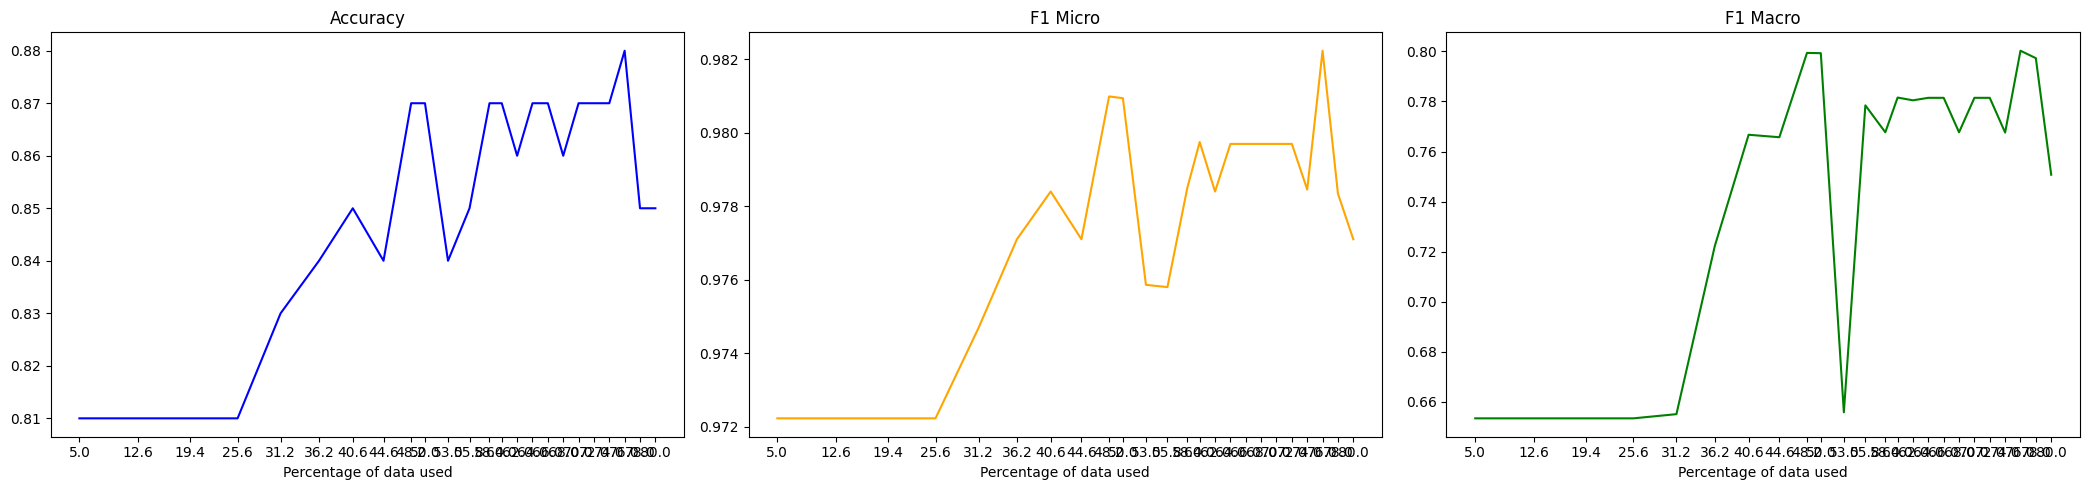

In [16]:
active_learning(seeds[0], 0)

## RUN 2

TRIAL 2
Random seed: 81


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.427260,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.301268,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.235869,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.204235,0.810000,0.962500,0.982143,0.972222,0.653284
5,No log,0.186607,0.810000,0.962500,0.982143,0.972222,0.653284
6,No log,0.177279,0.810000,0.962500,0.982143,0.972222,0.653284
7,No log,0.172513,0.810000,0.962500,0.982143,0.972222,0.653284
8,No log,0.168742,0.810000,0.962500,0.982143,0.972222,0.653284
9,No log,0.166898,0.810000,0.962500,0.982143,0.972222,0.653284
10,No log,0.166246,0.810000,0.962500,0.982143,0.972222,0.653284


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.86      1.00      0.92        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.96       392
 samples avg       0.96      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 25: Accuracy: 0.81, F1 Micro: 0.9722222222222222, F1 Macro: 0.6532843428612597
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.86      1.00      0.92        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.96       392
 samples avg       0.96      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Threshold: 0.000697433645837009
Samples above threshold: 38
Acquired samples: 38
Sampling duration: 8.598233699798584 seconds
New train size: 63


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.252833,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.175696,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.159152,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.151795,0.810000,0.962500,0.982143,0.972222,0.653284
5,No log,0.145384,0.810000,0.962500,0.982143,0.972222,0.653284
6,No log,0.143657,0.810000,0.962500,0.982143,0.972222,0.653284
7,No log,0.141446,0.810000,0.962500,0.982143,0.972222,0.653284
8,No log,0.140957,0.810000,0.962500,0.982143,0.972222,0.653284
9,No log,0.139666,0.810000,0.962500,0.982143,0.972222,0.653284
10,No log,0.139454,0.810000,0.962500,0.982143,0.972222,0.653284


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.86      1.00      0.92        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.96       392
 samples avg       0.96      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 63: Accuracy: 0.81, F1 Micro: 0.9722222222222222, F1 Macro: 0.6532843428612597
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.86      1.00      0.92        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.96       392
 samples avg       0.96      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Threshold: 0.0003526921151205898
Samples above threshold: 34
Acquired samples: 34
Sampling duration: 7.781644344329834 seconds
New train size: 97


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.193468,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.152217,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.143672,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.137798,0.810000,0.962500,0.982143,0.972222,0.653284
5,No log,0.135366,0.810000,0.962500,0.982143,0.972222,0.653284
6,No log,0.134683,0.810000,0.962500,0.982143,0.972222,0.653284
7,No log,0.133525,0.810000,0.962500,0.982143,0.972222,0.653284
8,No log,0.131477,0.810000,0.962500,0.982143,0.972222,0.653284
9,No log,0.129910,0.810000,0.962500,0.982143,0.972222,0.653284
10,No log,0.129857,0.810000,0.962500,0.982143,0.972222,0.653284


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.86      1.00      0.92        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.96       392
 samples avg       0.96      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 97: Accuracy: 0.81, F1 Micro: 0.9722222222222222, F1 Macro: 0.6532843428612597
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.86      1.00      0.92        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.96       392
 samples avg       0.96      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Threshold: 0.0002013493940467015
Samples above threshold: 31
Acquired samples: 31
Sampling duration: 6.984097003936768 seconds
New train size: 128


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.177748,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.144826,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.137620,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.135928,0.810000,0.962500,0.982143,0.972222,0.653284
5,No log,0.130513,0.810000,0.962500,0.982143,0.972222,0.653284
6,No log,0.126597,0.810000,0.962500,0.982143,0.972222,0.653284
7,No log,0.121867,0.820000,0.964912,0.982143,0.973451,0.654117
8,No log,0.118482,0.830000,0.967337,0.982143,0.974684,0.654960
9,No log,0.117984,0.830000,0.967337,0.982143,0.974684,0.654960
10,No log,0.117414,0.830000,0.967337,0.982143,0.974684,0.654960


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.88      1.00      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 128: Accuracy: 0.83, F1 Micro: 0.9746835443037974, F1 Macro: 0.6549595805112519
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.88      1.00      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Threshold: 0.0001411915203789249
Samples above threshold: 28
Acquired samples: 28
Sampling duration: 6.308134078979492 seconds
New train size: 156


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.166799,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.144628,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.134966,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.131231,0.810000,0.962500,0.982143,0.972222,0.653284
5,No log,0.124593,0.830000,0.967337,0.982143,0.974684,0.654960
6,No log,0.119724,0.830000,0.967337,0.982143,0.974684,0.654960
7,No log,0.121715,0.830000,0.967337,0.982143,0.974684,0.654960
8,No log,0.120810,0.800000,0.971939,0.971939,0.971939,0.652721
9,No log,0.120306,0.810000,0.969620,0.977041,0.973316,0.653859
10,No log,0.120194,0.790000,0.969466,0.971939,0.970701,0.651863


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.88      1.00      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 156: Accuracy: 0.83, F1 Micro: 0.9746835443037974, F1 Macro: 0.6549595805112519
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.88      1.00      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Threshold: 9.055953414645054e-05
Samples above threshold: 25
Acquired samples: 25
Sampling duration: 5.7195422649383545 seconds
New train size: 181


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.158082,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.139704,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.133496,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.128225,0.810000,0.962500,0.982143,0.972222,0.653284
5,No log,0.123960,0.830000,0.967337,0.982143,0.974684,0.654960
6,No log,0.124533,0.820000,0.967254,0.979592,0.973384,0.653989
7,No log,0.121205,0.800000,0.971867,0.969388,0.970626,0.651705
8,No log,0.120917,0.820000,0.969620,0.977041,0.973316,0.653859
9,No log,0.121048,0.810000,0.969543,0.974490,0.972010,0.652866
10,No log,0.120928,0.800000,0.969466,0.971939,0.970701,0.651863


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.88      1.00      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 181: Accuracy: 0.83, F1 Micro: 0.9746835443037974, F1 Macro: 0.6549595805112519
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.88      1.00      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Threshold: 0.00012440765858627857
Samples above threshold: 22
Acquired samples: 22
Sampling duration: 5.187390565872192 seconds
New train size: 203


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.157406,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.137960,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.129275,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.123322,0.840000,0.974555,0.977041,0.975796,0.655587
5,No log,0.127982,0.810000,0.979275,0.964286,0.971722,0.652263
6,No log,0.120403,0.800000,0.974293,0.966837,0.970551,0.651543
7,No log,0.122324,0.820000,0.969620,0.977041,0.973316,0.653859
8,No log,0.123655,0.820000,0.971939,0.971939,0.971939,0.652721
9,No log,0.122368,0.790000,0.974227,0.964286,0.969231,0.650503
10,No log,0.122627,0.790000,0.974227,0.964286,0.969231,0.650503


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.65      0.66      0.66       392
weighted avg       0.96      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 203: Accuracy: 0.84, F1 Micro: 0.975796178343949, F1 Macro: 0.6555870600675632
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.65      0.66      0.66       392
weighted avg       0.96      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Threshold: 0.00014838477654848255
Samples above threshold: 20
Acquired samples: 20
Sampling duration: 4.708299398422241 seconds
New train size: 223


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.155893,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.136731,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.131146,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.125301,0.820000,0.964912,0.982143,0.973451,0.654117
5,No log,0.120739,0.810000,0.974359,0.969388,0.971867,0.652572
6,No log,0.117087,0.830000,0.972081,0.977041,0.974555,0.654718
7,No log,0.116502,0.820000,0.974425,0.971939,0.973180,0.653588
8,No log,0.114712,0.800000,0.974293,0.966837,0.970551,0.651543
9,No log,0.114397,0.800000,0.974293,0.966837,0.970551,0.651543
10,No log,0.113960,0.800000,0.974293,0.966837,0.970551,0.651543


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      0.98      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.97       392
   macro avg       0.65      0.66      0.65       392
weighted avg       0.96      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 223: Accuracy: 0.83, F1 Micro: 0.9745547073791349, F1 Macro: 0.6547180346175321
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      0.98      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.97       392
   macro avg       0.65      0.66      0.65       392
weighted avg       0.96      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Threshold: 0.0001267439249204472
Samples above threshold: 18
Acquired samples: 18
Sampling duration: 4.307358503341675 seconds
New train size: 241


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.147043,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.135931,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.130604,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.117901,0.840000,0.969773,0.982143,0.975919,0.655811
5,No log,0.113505,0.810000,0.974359,0.969388,0.971867,0.652572
6,No log,0.112667,0.820000,0.972010,0.974490,0.973248,0.653725
7,No log,0.110993,0.790000,0.974227,0.964286,0.969231,0.650503
8,No log,0.111703,0.830000,0.972081,0.977041,0.974555,0.654718
9,No log,0.111590,0.840000,0.972152,0.979592,0.975858,0.721385
10,No log,0.110456,0.820000,0.972010,0.974490,0.973248,0.653725


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      1.00      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.65      0.67      0.66       392
weighted avg       0.95      0.98      0.97       392
 samples avg       0.97      0.98      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 241: Accuracy: 0.84, F1 Micro: 0.9759188846641319, F1 Macro: 0.6558109307923955
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      1.00      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.65      0.67      0.66       392
weighted avg       0.95      0.98      0.97       392
 samples avg       0.97      0.98      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Threshold: 6.837594992248343e-05
Samples above threshold: 16
Acquired samples: 9
Sampling duration: 3.8791866302490234 seconds
New train size: 250


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.146662,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.138299,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.128311,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.123309,0.830000,0.967337,0.982143,0.974684,0.654960
5,No log,0.113596,0.830000,0.972081,0.977041,0.974555,0.654718
6,No log,0.112512,0.800000,0.974359,0.969388,0.971867,0.652572
7,No log,0.113803,0.820000,0.974490,0.974490,0.974490,0.654593
8,No log,0.110072,0.790000,0.974293,0.966837,0.970551,0.651543
9,No log,0.111415,0.820000,0.974490,0.974490,0.974490,0.720255
10,No log,0.110157,0.820000,0.972010,0.974490,0.973248,0.653725


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.88      1.00      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 250: Accuracy: 0.83, F1 Micro: 0.9746835443037974, F1 Macro: 0.6549595805112519
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.88      1.00      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 300
Threshold: 0.00010649391915649175
Samples above threshold: 15
Acquired samples: 15
Sampling duration: 3.740630865097046 seconds
New train size: 265


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.147410,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.137221,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.128849,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.124316,0.830000,0.967337,0.982143,0.974684,0.654960
5,No log,0.119169,0.800000,0.981818,0.964286,0.972973,0.653159
6,No log,0.113400,0.800000,0.974359,0.969388,0.971867,0.652572
7,No log,0.114814,0.810000,0.969543,0.974490,0.972010,0.718529
8,No log,0.112132,0.800000,0.976804,0.966837,0.971795,0.718045
9,No log,0.110755,0.820000,0.976923,0.971939,0.974425,0.720115
10,No log,0.110495,0.820000,0.976923,0.971939,0.974425,0.720115


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.88      1.00      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 265: Accuracy: 0.83, F1 Micro: 0.9746835443037974, F1 Macro: 0.6549595805112519
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.88      1.00      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 300
Threshold: 0.0001511516747996211
Samples above threshold: 14
Acquired samples: 14
Sampling duration: 3.3040895462036133 seconds
New train size: 279


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.158287,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.138412,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.124419,0.820000,0.964912,0.982143,0.973451,0.654117
4,No log,0.119700,0.820000,0.972010,0.974490,0.973248,0.719387
5,No log,0.113421,0.840000,0.969773,0.982143,0.975919,0.721507
6,No log,0.107964,0.820000,0.976923,0.971939,0.974425,0.720115
7,No log,0.111934,0.800000,0.974359,0.969388,0.971867,0.718210
8,No log,0.111267,0.820000,0.974490,0.974490,0.974490,0.763683
9,No log,0.111591,0.840000,0.977041,0.977041,0.977041,0.796305
10,No log,0.111937,0.840000,0.977041,0.977041,0.977041,0.796305


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.75      0.86         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.94      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.98      0.98      0.98       392
   macro avg       0.82      0.78      0.80       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.98      0.98      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 279: Accuracy: 0.84, F1 Micro: 0.9770408163265306, F1 Macro: 0.7963053362048337
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.75      0.86         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.94      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.98      0.98      0.98       392
   macro avg       0.82      0.78      0.80       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.98      0.98      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 300
Threshold: 0.00020709277305286378
Samples above threshold: 13
Acquired samples: 13
Sampling duration: 3.0373008251190186 seconds
New train size: 292


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.148720,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.137421,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.124561,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.115310,0.820000,0.974490,0.974490,0.974490,0.654593
5,No log,0.109499,0.820000,0.976923,0.971939,0.974425,0.720115
6,No log,0.110794,0.830000,0.972081,0.977041,0.974555,0.748826
7,No log,0.110771,0.810000,0.974425,0.971939,0.973180,0.747657
8,No log,0.107188,0.820000,0.974490,0.974490,0.974490,0.763683
9,No log,0.105996,0.810000,0.974425,0.971939,0.973180,0.762655
10,No log,0.107450,0.820000,0.974490,0.974490,0.974490,0.794401


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.67      0.50      0.57         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.95      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.97       392
   macro avg       0.76      0.74      0.75       392
weighted avg       0.96      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 292: Accuracy: 0.83, F1 Micro: 0.9745547073791349, F1 Macro: 0.7488261863528024
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.67      0.50      0.57         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.95      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.97       392
   macro avg       0.76      0.74      0.75       392
weighted avg       0.96      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 300
Threshold: 0.0003293156856670972
Samples above threshold: 11
Acquired samples: 8
Sampling duration: 2.775526523590088 seconds
New train size: 300


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.147396,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.135871,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.123812,0.820000,0.964912,0.982143,0.973451,0.654117
4,No log,0.111171,0.820000,0.974490,0.974490,0.974490,0.654593
5,No log,0.107790,0.850000,0.972222,0.982143,0.977157,0.722367
6,No log,0.112402,0.860000,0.972292,0.984694,0.978454,0.766811
7,No log,0.105738,0.830000,0.976982,0.974490,0.975734,0.721132
8,No log,0.108933,0.840000,0.972222,0.982143,0.977157,0.779593
9,No log,0.109242,0.840000,0.972152,0.979592,0.975858,0.765577
10,No log,0.108777,0.840000,0.974619,0.979592,0.977099,0.779466


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.50      0.67         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      0.99      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.81      0.75      0.77       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 300: Accuracy: 0.86, F1 Micro: 0.9784537389100126, F1 Macro: 0.7668113433959237
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.50      0.67         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      0.99      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.81      0.75      0.77       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 350
Threshold: 8.7019074271666e-05
Samples above threshold: 10
Acquired samples: 10
Sampling duration: 2.5458414554595947 seconds
New train size: 310


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.145612,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.140293,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.122655,0.830000,0.967337,0.982143,0.974684,0.654960
4,No log,0.109012,0.830000,0.974555,0.977041,0.975796,0.655587
5,No log,0.110980,0.830000,0.972152,0.979592,0.975858,0.778588
6,No log,0.105527,0.840000,0.969773,0.982143,0.975919,0.765704
7,No log,0.109911,0.860000,0.969925,0.987245,0.978508,0.780700
8,No log,0.107648,0.840000,0.979487,0.974490,0.976982,0.796162
9,No log,0.105635,0.860000,0.974747,0.984694,0.979695,0.798444
10,No log,0.103627,0.850000,0.974684,0.982143,0.978399,0.797450


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.75      0.86         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.82      0.79      0.80       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 310: Accuracy: 0.86, F1 Micro: 0.9796954314720812, F1 Macro: 0.798444202924706
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.75      0.86         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.82      0.79      0.80       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 350
Threshold: 3.8570348624489274e-05
Samples above threshold: 9
Acquired samples: 10
Sampling duration: 2.3789727687835693 seconds
New train size: 320


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.145855,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.135038,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.122517,0.840000,0.969773,0.982143,0.975919,0.655811
4,No log,0.114003,0.840000,0.969773,0.982143,0.975919,0.655811
5,No log,0.111777,0.850000,0.969849,0.984694,0.977215,0.722478
6,No log,0.104269,0.840000,0.974619,0.979592,0.977099,0.722254
7,No log,0.101724,0.830000,0.972081,0.977041,0.974555,0.710149
8,No log,0.104092,0.850000,0.969849,0.984694,0.977215,0.766698
9,No log,0.103709,0.850000,0.969849,0.984694,0.977215,0.766698
10,No log,0.103161,0.830000,0.972081,0.977041,0.974555,0.764559


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.25      0.40         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      1.00      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.81      0.71      0.72       392
weighted avg       0.96      0.98      0.97       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 320: Accuracy: 0.85, F1 Micro: 0.9772151898734177, F1 Macro: 0.7224775974590621
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.25      0.40         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      1.00      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.81      0.71      0.72       392
weighted avg       0.96      0.98      0.97       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 350
Threshold: 6.315157370409011e-05
Samples above threshold: 8
Acquired samples: 10
Sampling duration: 2.1032514572143555 seconds
New train size: 330


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.142500,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.132392,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.142014,0.820000,0.964912,0.982143,0.973451,0.654117
4,No log,0.112662,0.830000,0.972152,0.979592,0.975858,0.721385
5,No log,0.111379,0.840000,0.967419,0.984694,0.975980,0.750078
6,No log,0.120486,0.820000,0.974425,0.971939,0.973180,0.763374
7,No log,0.111530,0.830000,0.969697,0.979592,0.974619,0.764699
8,No log,0.104017,0.850000,0.969849,0.984694,0.977215,0.766698
9,No log,0.104673,0.840000,0.969773,0.982143,0.975919,0.765704
10,No log,0.102980,0.830000,0.969697,0.979592,0.974619,0.764699


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.60      0.75      0.67         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.75      0.79      0.77       392
weighted avg       0.96      0.98      0.97       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 330: Accuracy: 0.85, F1 Micro: 0.9772151898734177, F1 Macro: 0.7666981711786742
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.60      0.75      0.67         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.75      0.79      0.77       392
weighted avg       0.96      0.98      0.97       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 350
Threshold: 3.287634317530319e-05
Samples above threshold: 7
Acquired samples: 10
Sampling duration: 1.915616750717163 seconds
New train size: 340


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.142684,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.126648,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.113858,0.830000,0.967337,0.982143,0.974684,0.654960
4,No log,0.111172,0.840000,0.974619,0.979592,0.977099,0.722254
5,No log,0.104143,0.830000,0.974555,0.977041,0.975796,0.721260
6,No log,0.107379,0.860000,0.969925,0.987245,0.978508,0.767681
7,No log,0.102615,0.840000,0.974619,0.979592,0.977099,0.779466
8,No log,0.103127,0.840000,0.977041,0.977041,0.977041,0.796305
9,No log,0.102689,0.840000,0.972222,0.982143,0.977157,0.779593
10,No log,0.102927,0.840000,0.972152,0.979592,0.975858,0.765577


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.60      0.75      0.67         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.99      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.75      0.79      0.77       392
weighted avg       0.96      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 340: Accuracy: 0.86, F1 Micro: 0.9785082174462705, F1 Macro: 0.767680997580495
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.60      0.75      0.67         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.99      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.75      0.79      0.77       392
weighted avg       0.96      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 350
Threshold: 4.942404448229354e-05
Samples above threshold: 6
Acquired samples: 10
Sampling duration: 1.8365120887756348 seconds
New train size: 350


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.140354,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.129741,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.118639,0.820000,0.964912,0.982143,0.973451,0.654117
4,No log,0.117273,0.800000,0.976804,0.966837,0.971795,0.652419
5,No log,0.107292,0.860000,0.974747,0.984694,0.979695,0.798444
6,No log,0.102153,0.820000,0.976923,0.971939,0.974425,0.720115
7,No log,0.105160,0.830000,0.974555,0.977041,0.975796,0.795429
8,No log,0.104232,0.860000,0.972292,0.984694,0.978454,0.780587
9,No log,0.104474,0.860000,0.969925,0.987245,0.978508,0.767681
10,No log,0.102499,0.860000,0.972292,0.984694,0.978454,0.780587


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.75      0.86         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.82      0.79      0.80       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 350: Accuracy: 0.86, F1 Micro: 0.9796954314720812, F1 Macro: 0.798444202924706
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.75      0.86         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.82      0.79      0.80       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 400
Threshold: 7.513341843150556e-05
Samples above threshold: 5
Acquired samples: 10
Sampling duration: 1.4917256832122803 seconds
New train size: 360


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.146175,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.131262,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.125560,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.108688,0.820000,0.972081,0.977041,0.974555,0.654718
5,No log,0.111327,0.790000,0.979275,0.964286,0.971722,0.717876
6,No log,0.108173,0.840000,0.967419,0.984694,0.975980,0.765829
7,No log,0.106066,0.840000,0.967419,0.984694,0.975980,0.765829
8,No log,0.102156,0.830000,0.967337,0.982143,0.974684,0.764836
9,No log,0.101243,0.820000,0.974490,0.974490,0.974490,0.720255
10,No log,0.101698,0.840000,0.969773,0.982143,0.975919,0.778725


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.60      0.75      0.67         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      0.98      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.75      0.79      0.77       392
weighted avg       0.96      0.98      0.97       392
 samples avg       0.97      0.99      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 360: Accuracy: 0.84, F1 Micro: 0.9759797724399494, F1 Macro: 0.7658291457286431
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.60      0.75      0.67         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      0.98      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.75      0.79      0.77       392
weighted avg       0.96      0.98      0.97       392
 samples avg       0.97      0.99      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 400
Threshold: 5.619995899905923e-05
Samples above threshold: 4
Acquired samples: 10
Sampling duration: 1.2652077674865723 seconds
New train size: 370


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.140351,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.129468,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.120423,0.830000,0.967337,0.982143,0.974684,0.654960
4,No log,0.108458,0.840000,0.972222,0.982143,0.977157,0.722367
5,No log,0.107984,0.840000,0.969773,0.982143,0.975919,0.721507
6,No log,0.110804,0.840000,0.972152,0.979592,0.975858,0.765577
7,No log,0.102292,0.870000,0.977157,0.982143,0.979644,0.781359
8,No log,0.101207,0.880000,0.979644,0.982143,0.980892,0.782258
9,No log,0.100859,0.860000,0.974684,0.982143,0.978399,0.780471
10,No log,0.100144,0.870000,0.977157,0.982143,0.979644,0.781359


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.75      0.75      0.75         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.93      0.97      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.98      0.98      0.98       392
   macro avg       0.78      0.79      0.78       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.98      0.98      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 370: Accuracy: 0.88, F1 Micro: 0.9808917197452229, F1 Macro: 0.7822577171572146
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.75      0.75      0.75         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.93      0.97      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.98      0.98      0.98       392
   macro avg       0.78      0.79      0.78       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.98      0.98      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 400
Threshold: 5.277318923617716e-05
Samples above threshold: 3
Acquired samples: 10
Sampling duration: 1.0050957202911377 seconds
New train size: 380


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.145366,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.131491,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.119696,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.110236,0.830000,0.974555,0.977041,0.975796,0.655587
5,No log,0.102888,0.850000,0.977099,0.979592,0.978344,0.797323
6,No log,0.100107,0.850000,0.974619,0.979592,0.977099,0.779466
7,No log,0.100955,0.840000,0.969773,0.982143,0.975919,0.765704
8,No log,0.101681,0.840000,0.972152,0.979592,0.975858,0.765577
9,No log,0.100178,0.830000,0.972081,0.977041,0.974555,0.764559
10,No log,0.099467,0.840000,0.974555,0.977041,0.975796,0.778448


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.75      0.86         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.95      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.98      0.98      0.98       392
   macro avg       0.82      0.78      0.80       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.98      0.98      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 380: Accuracy: 0.85, F1 Micro: 0.9783439490445859, F1 Macro: 0.7973226522221498
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.75      0.86         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.95      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.98      0.98      0.98       392
   macro avg       0.82      0.78      0.80       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.98      0.98      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 400
Threshold: 1.9259751570643858e-05
Samples above threshold: 2
Acquired samples: 10
Sampling duration: 0.7345860004425049 seconds
New train size: 390


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.145423,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.126432,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.116830,0.840000,0.969773,0.982143,0.975919,0.655811
4,No log,0.110107,0.840000,0.977041,0.977041,0.977041,0.722138
5,No log,0.104166,0.800000,0.976804,0.966837,0.971795,0.761436
6,No log,0.101566,0.860000,0.972292,0.984694,0.978454,0.780587
7,No log,0.104288,0.850000,0.967500,0.987245,0.977273,0.766811
8,No log,0.101410,0.840000,0.972152,0.979592,0.975858,0.778588
9,No log,0.100564,0.840000,0.972152,0.979592,0.975858,0.778588
10,No log,0.100587,0.840000,0.972152,0.979592,0.975858,0.778588


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.75      0.75      0.75         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.77      0.79      0.78       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 390: Accuracy: 0.86, F1 Micro: 0.9784537389100126, F1 Macro: 0.7805870600675631
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.75      0.75      0.75         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.77      0.79      0.78       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 400
Threshold: 2.4708380806259808e-05
Samples above threshold: 1
Acquired samples: 10
Sampling duration: 0.534508228302002 seconds
New train size: 400


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.149288,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.123698,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.112581,0.830000,0.967337,0.982143,0.974684,0.654960
4,No log,0.104061,0.830000,0.972152,0.979592,0.975858,0.655700
5,No log,0.101799,0.840000,0.977041,0.977041,0.977041,0.779335
6,No log,0.104897,0.840000,0.974555,0.977041,0.975796,0.778448
7,No log,0.100561,0.850000,0.969849,0.984694,0.977215,0.787927
8,No log,0.098335,0.850000,0.972222,0.982143,0.977157,0.779593
9,No log,0.097971,0.840000,0.972152,0.979592,0.975858,0.778588
10,0.097500,0.099189,0.840000,0.972152,0.979592,0.975858,0.778588


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.67      1.00      0.80         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.97      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.76      0.83      0.79       392
weighted avg       0.96      0.98      0.97       392
 samples avg       0.97      0.98      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 400: Accuracy: 0.85, F1 Micro: 0.9772151898734177, F1 Macro: 0.7879265240057967
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.67      1.00      0.80         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.97      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.76      0.83      0.79       392
weighted avg       0.96      0.98      0.97       392
 samples avg       0.97      0.98      0.98       392

Total sampling time: 82.14 seconds
Total runtime: 2749.589174747467 seconds


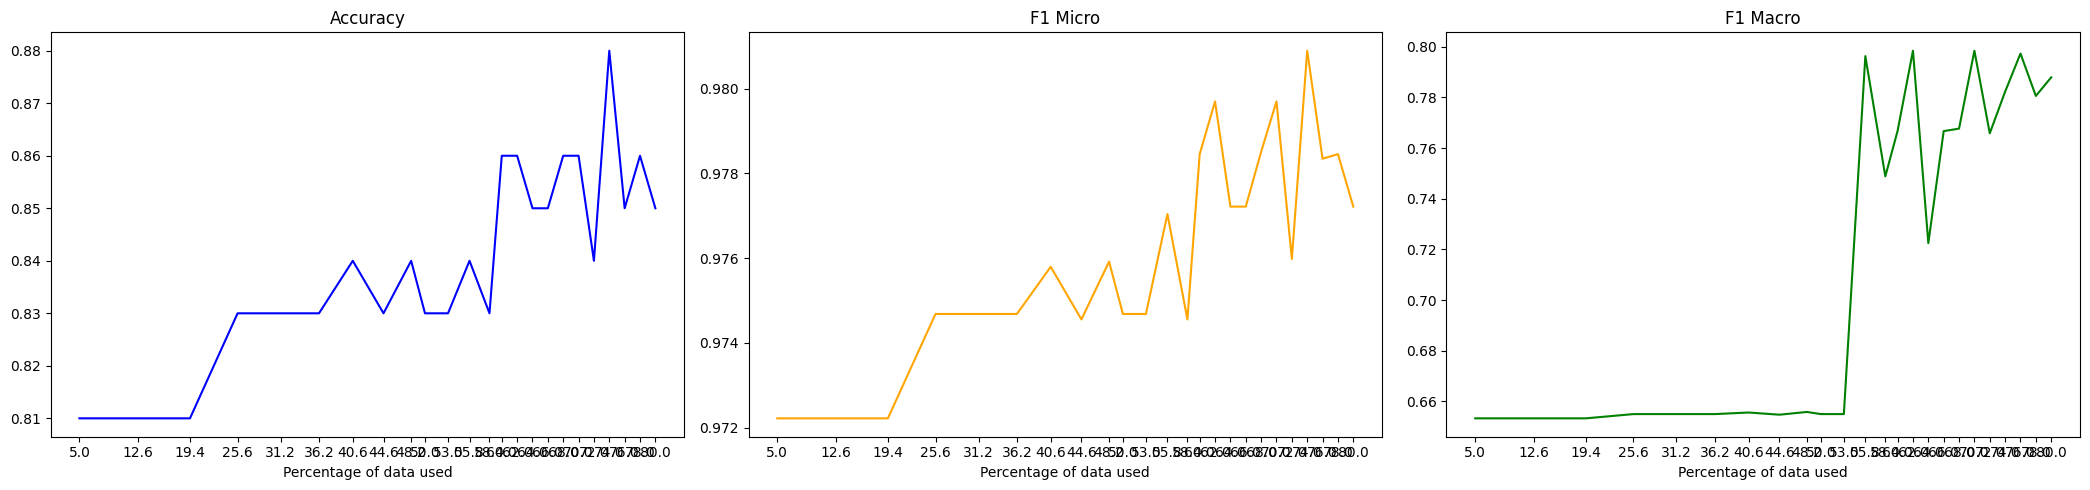

In [17]:
active_learning(seeds[1], 1)

## RUN 3

TRIAL 3
Random seed: 14


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.397611,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.288708,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.231498,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.205215,0.810000,0.962500,0.982143,0.972222,0.653284
5,No log,0.187409,0.810000,0.962500,0.982143,0.972222,0.653284
6,No log,0.178176,0.810000,0.962500,0.982143,0.972222,0.653284
7,No log,0.173865,0.810000,0.962500,0.982143,0.972222,0.653284
8,No log,0.169992,0.810000,0.962500,0.982143,0.972222,0.653284
9,No log,0.167555,0.810000,0.962500,0.982143,0.972222,0.653284
10,No log,0.166610,0.810000,0.962500,0.982143,0.972222,0.653284


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.86      1.00      0.92        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.96       392
 samples avg       0.96      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 25: Accuracy: 0.81, F1 Micro: 0.9722222222222222, F1 Macro: 0.6532843428612597
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.86      1.00      0.92        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.96       392
 samples avg       0.96      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Threshold: 0.0007311380468308927
Samples above threshold: 38
Acquired samples: 38
Sampling duration: 8.563184022903442 seconds
New train size: 63


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.267234,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.185517,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.161142,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.151551,0.810000,0.962500,0.982143,0.972222,0.653284
5,No log,0.146681,0.810000,0.962500,0.982143,0.972222,0.653284
6,No log,0.144019,0.810000,0.962500,0.982143,0.972222,0.653284
7,No log,0.141805,0.810000,0.962500,0.982143,0.972222,0.653284
8,No log,0.141282,0.810000,0.962500,0.982143,0.972222,0.653284
9,No log,0.141079,0.800000,0.962406,0.979592,0.970923,0.652316
10,No log,0.141003,0.800000,0.962406,0.979592,0.970923,0.652316


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.86      1.00      0.92        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.96       392
 samples avg       0.96      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 63: Accuracy: 0.81, F1 Micro: 0.9722222222222222, F1 Macro: 0.6532843428612597
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.86      1.00      0.92        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.96       392
 samples avg       0.96      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Threshold: 0.00039673683349974456
Samples above threshold: 34
Acquired samples: 34
Sampling duration: 7.743261098861694 seconds
New train size: 97


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.200783,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.164434,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.150383,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.145075,0.810000,0.962500,0.982143,0.972222,0.653284
5,No log,0.140772,0.810000,0.962500,0.982143,0.972222,0.653284
6,No log,0.141302,0.810000,0.962500,0.982143,0.972222,0.653284
7,No log,0.139420,0.810000,0.962500,0.982143,0.972222,0.653284
8,No log,0.140592,0.790000,0.962312,0.977041,0.969620,0.651336
9,No log,0.138474,0.790000,0.962312,0.977041,0.969620,0.651336
10,No log,0.138763,0.790000,0.962312,0.977041,0.969620,0.651336


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.86      1.00      0.92        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.96       392
 samples avg       0.96      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 97: Accuracy: 0.81, F1 Micro: 0.9722222222222222, F1 Macro: 0.6532843428612597
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.86      1.00      0.92        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.96       392
 samples avg       0.96      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Threshold: 0.00020639649592339994
Samples above threshold: 31
Acquired samples: 31
Sampling duration: 6.977773666381836 seconds
New train size: 128


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.183374,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.154030,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.143690,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.139226,0.810000,0.962500,0.982143,0.972222,0.653284
5,No log,0.134456,0.810000,0.962500,0.982143,0.972222,0.653284
6,No log,0.132622,0.810000,0.962500,0.982143,0.972222,0.653284
7,No log,0.132437,0.830000,0.967337,0.982143,0.974684,0.654960
8,No log,0.130822,0.820000,0.969697,0.979592,0.974619,0.654840
9,No log,0.129540,0.820000,0.969697,0.979592,0.974619,0.654840
10,No log,0.129921,0.820000,0.969697,0.979592,0.974619,0.654840


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.88      1.00      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 128: Accuracy: 0.83, F1 Micro: 0.9746835443037974, F1 Macro: 0.6549595805112519
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.88      1.00      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Threshold: 0.0001226754022354726
Samples above threshold: 28
Acquired samples: 28
Sampling duration: 6.303885459899902 seconds
New train size: 156


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.169365,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.146141,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.138645,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.132203,0.820000,0.967337,0.982143,0.974684,0.654960
5,No log,0.127672,0.840000,0.972222,0.982143,0.977157,0.656672
6,No log,0.132229,0.830000,0.969773,0.982143,0.975919,0.655811
7,No log,0.126125,0.790000,0.974293,0.966837,0.970551,0.651543
8,No log,0.130135,0.770000,0.976623,0.959184,0.967825,0.649260
9,No log,0.128882,0.770000,0.971722,0.964286,0.967990,0.649639
10,No log,0.129754,0.740000,0.973958,0.954082,0.963918,0.646221


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      1.00      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.65      0.67      0.66       392
weighted avg       0.96      0.98      0.97       392
 samples avg       0.97      0.98      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 156: Accuracy: 0.84, F1 Micro: 0.9771573604060914, F1 Macro: 0.6566716365711341
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      1.00      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.65      0.67      0.66       392
weighted avg       0.96      0.98      0.97       392
 samples avg       0.97      0.98      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Threshold: 0.00012406953464960682
Samples above threshold: 25
Acquired samples: 25
Sampling duration: 5.737802267074585 seconds
New train size: 181


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.161728,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.142936,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.140709,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.128933,0.810000,0.962500,0.982143,0.972222,0.653284
5,No log,0.131033,0.830000,0.967337,0.982143,0.974684,0.654960
6,No log,0.123146,0.810000,0.974425,0.971939,0.973180,0.653588
7,No log,0.120899,0.810000,0.972010,0.974490,0.973248,0.653725
8,No log,0.120667,0.800000,0.971939,0.971939,0.971939,0.652721
9,No log,0.121093,0.800000,0.971939,0.971939,0.971939,0.652721
10,No log,0.120714,0.800000,0.971939,0.971939,0.971939,0.652721


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.88      1.00      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 181: Accuracy: 0.83, F1 Micro: 0.9746835443037974, F1 Macro: 0.6549595805112519
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.88      1.00      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Threshold: 0.00011769839184125891
Samples above threshold: 22
Acquired samples: 22
Sampling duration: 5.171202659606934 seconds
New train size: 203


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.162697,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.149579,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.137188,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.121414,0.830000,0.972152,0.979592,0.975858,0.655700
5,No log,0.122172,0.830000,0.976923,0.971939,0.974425,0.654466
6,No log,0.119498,0.810000,0.972010,0.974490,0.973248,0.653725
7,No log,0.116505,0.820000,0.976923,0.971939,0.974425,0.654466
8,No log,0.119744,0.820000,0.976864,0.969388,0.973111,0.719086
9,No log,0.115463,0.810000,0.972010,0.974490,0.973248,0.719387
10,No log,0.115625,0.820000,0.974490,0.974490,0.974490,0.720255


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      0.99      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.65      0.66      0.66       392
weighted avg       0.96      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 203: Accuracy: 0.83, F1 Micro: 0.9758576874205843, F1 Macro: 0.6557002322848127
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      0.99      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.65      0.66      0.66       392
weighted avg       0.96      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Threshold: 8.892780897440389e-05
Samples above threshold: 20
Acquired samples: 20
Sampling duration: 4.692600250244141 seconds
New train size: 223


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.153963,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.140843,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.128196,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.122116,0.810000,0.972010,0.974490,0.973248,0.653725
5,No log,0.123548,0.830000,0.969773,0.982143,0.975919,0.655811
6,No log,0.115196,0.800000,0.976804,0.966837,0.971795,0.652419
7,No log,0.111662,0.820000,0.974490,0.974490,0.974490,0.763683
8,No log,0.111878,0.820000,0.974490,0.974490,0.974490,0.794401
9,No log,0.111473,0.820000,0.974490,0.974490,0.974490,0.794401
10,No log,0.110097,0.850000,0.974684,0.982143,0.978399,0.797450


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.75      0.86         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.97      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.82      0.79      0.80       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.97      0.98      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 223: Accuracy: 0.85, F1 Micro: 0.9783989834815755, F1 Macro: 0.7974503335296063
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.75      0.86         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.97      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.82      0.79      0.80       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.97      0.98      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Threshold: 0.0004265765252057463
Samples above threshold: 18
Acquired samples: 18
Sampling duration: 4.301799058914185 seconds
New train size: 241


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.151765,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.137904,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.133504,0.830000,0.967337,0.982143,0.974684,0.654960
4,No log,0.129543,0.830000,0.972152,0.979592,0.975858,0.655700
5,No log,0.112846,0.800000,0.976744,0.964286,0.970475,0.760371
6,No log,0.107245,0.820000,0.976923,0.971939,0.974425,0.794235
7,No log,0.109790,0.860000,0.974747,0.984694,0.979695,0.798444
8,No log,0.108533,0.840000,0.974619,0.979592,0.977099,0.796445
9,No log,0.106935,0.840000,0.974619,0.979592,0.977099,0.796445
10,No log,0.106963,0.840000,0.974619,0.979592,0.977099,0.796445


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.75      0.86         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.82      0.79      0.80       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 241: Accuracy: 0.86, F1 Micro: 0.9796954314720812, F1 Macro: 0.798444202924706
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.75      0.86         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.82      0.79      0.80       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Threshold: 0.00014434810727834745
Samples above threshold: 16
Acquired samples: 9
Sampling duration: 3.8849079608917236 seconds
New train size: 250


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.154074,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.155930,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.129747,0.830000,0.969773,0.982143,0.975919,0.655811
4,No log,0.113936,0.820000,0.976864,0.969388,0.973111,0.653448
5,No log,0.111970,0.810000,0.979275,0.964286,0.971722,0.791921
6,No log,0.106888,0.840000,0.976982,0.974490,0.975734,0.795276
7,No log,0.104856,0.810000,0.976804,0.966837,0.971795,0.792117
8,No log,0.104594,0.850000,0.977099,0.979592,0.978344,0.797323
9,No log,0.103935,0.850000,0.977041,0.977041,0.977041,0.796305
10,No log,0.103577,0.850000,0.977099,0.979592,0.978344,0.797323


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.75      0.86         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.95      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.98      0.98      0.98       392
   macro avg       0.82      0.78      0.80       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.98      0.98      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 250: Accuracy: 0.85, F1 Micro: 0.9783439490445859, F1 Macro: 0.7973226522221498
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.75      0.86         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.95      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.98      0.98      0.98       392
   macro avg       0.82      0.78      0.80       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.98      0.98      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 300
Threshold: 0.00012689832219621168
Samples above threshold: 15
Acquired samples: 15
Sampling duration: 3.688918113708496 seconds
New train size: 265


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.149298,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.143068,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.143725,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.115886,0.830000,0.969773,0.982143,0.975919,0.655811
5,No log,0.105540,0.860000,0.972362,0.987245,0.979747,0.798557
6,No log,0.105238,0.840000,0.967500,0.987245,0.977273,0.766811
7,No log,0.104320,0.840000,0.969849,0.984694,0.977215,0.766698
8,No log,0.101547,0.830000,0.974555,0.977041,0.975796,0.778448
9,No log,0.101569,0.840000,0.974619,0.979592,0.977099,0.779466
10,No log,0.100915,0.860000,0.977157,0.982143,0.979644,0.798328


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.75      0.86         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      0.99      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.81      0.79      0.80       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 265: Accuracy: 0.86, F1 Micro: 0.979746835443038, F1 Macro: 0.7985573751419555
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.75      0.86         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      0.99      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.81      0.79      0.80       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 300
Threshold: 0.00010841148468898615
Samples above threshold: 14
Acquired samples: 14
Sampling duration: 3.3087151050567627 seconds
New train size: 279


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.154074,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.142002,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.133345,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.114194,0.830000,0.967337,0.982143,0.974684,0.654960
5,No log,0.109303,0.820000,0.967337,0.982143,0.974684,0.754593
6,No log,0.102759,0.840000,0.972222,0.982143,0.977157,0.766582
7,No log,0.107323,0.810000,0.964824,0.979592,0.972152,0.764559
8,No log,0.105204,0.820000,0.969697,0.979592,0.974619,0.765577
9,No log,0.104788,0.820000,0.969697,0.979592,0.974619,0.765577
10,No log,0.108310,0.810000,0.964912,0.982143,0.973451,0.765577


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.60      0.75      0.67         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.97      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.75      0.79      0.77       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.97      0.98      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 279: Accuracy: 0.84, F1 Micro: 0.9771573604060914, F1 Macro: 0.7665824413971931
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.60      0.75      0.67         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.97      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.75      0.79      0.77       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.97      0.98      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 300
Threshold: 7.163416012190282e-05
Samples above threshold: 13
Acquired samples: 13
Sampling duration: 3.070490837097168 seconds
New train size: 292


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.151940,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.138346,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.123482,0.830000,0.967337,0.982143,0.974684,0.654960
4,No log,0.136478,0.840000,0.972222,0.982143,0.977157,0.656672
5,No log,0.110348,0.830000,0.979381,0.969388,0.974359,0.763374
6,No log,0.103277,0.880000,0.977273,0.987245,0.982234,0.800306
7,No log,0.101682,0.850000,0.977099,0.979592,0.978344,0.797323
8,No log,0.100251,0.840000,0.977041,0.977041,0.977041,0.796305
9,No log,0.100240,0.840000,0.977041,0.977041,0.977041,0.796305
10,No log,0.101349,0.870000,0.977215,0.984694,0.980940,0.799323


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.75      0.86         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.99      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.98      0.99      0.98       392
   macro avg       0.82      0.79      0.80       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.98      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 292: Accuracy: 0.88, F1 Micro: 0.9822335025380711, F1 Macro: 0.8003064003176297
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.75      0.86         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.99      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.98      0.99      0.98       392
   macro avg       0.82      0.79      0.80       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.98      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 300
Threshold: 5.853292386746034e-05
Samples above threshold: 11
Acquired samples: 8
Sampling duration: 2.787234306335449 seconds
New train size: 300


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.148715,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.136671,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.126806,0.810000,0.972010,0.974490,0.973248,0.653725
4,No log,0.109443,0.860000,0.974747,0.984694,0.979695,0.798444
5,No log,0.106517,0.820000,0.974490,0.974490,0.974490,0.794401
6,No log,0.107676,0.830000,0.974555,0.977041,0.975796,0.819086
7,No log,0.106517,0.810000,0.972010,0.974490,0.973248,0.777419
8,No log,0.102793,0.820000,0.976923,0.971939,0.974425,0.794235
9,No log,0.108477,0.810000,0.972010,0.974490,0.973248,0.777419
10,No log,0.105562,0.810000,0.969620,0.977041,0.973316,0.777572


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.75      0.86         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.82      0.79      0.80       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 300: Accuracy: 0.86, F1 Micro: 0.9796954314720812, F1 Macro: 0.798444202924706
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.75      0.86         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.82      0.79      0.80       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 350
Threshold: 8.914789505070077e-05
Samples above threshold: 10
Acquired samples: 10
Sampling duration: 2.6468944549560547 seconds
New train size: 310


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.152116,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.139952,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.134639,0.840000,0.972222,0.982143,0.977157,0.656672
4,No log,0.111141,0.850000,0.977099,0.979592,0.978344,0.797323
5,No log,0.106568,0.860000,0.972362,0.987245,0.979747,0.798557
6,No log,0.101775,0.830000,0.976923,0.971939,0.974425,0.794235
7,No log,0.100475,0.870000,0.974811,0.987245,0.980989,0.799427
8,No log,0.103286,0.870000,0.974811,0.987245,0.980989,0.804614
9,No log,0.098553,0.860000,0.977157,0.982143,0.979644,0.798328
10,No log,0.099292,0.860000,0.977157,0.982143,0.979644,0.798328


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.75      0.86         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.99      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.82      0.79      0.80       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 310: Accuracy: 0.87, F1 Micro: 0.9809885931558936, F1 Macro: 0.7994270293265268
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.75      0.86         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.99      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.82      0.79      0.80       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 350
Threshold: 3.1742520877742226e-05
Samples above threshold: 9
Acquired samples: 10
Sampling duration: 2.334174633026123 seconds
New train size: 320


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.154568,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.131539,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.115777,0.820000,0.972081,0.977041,0.974555,0.654718
4,No log,0.123400,0.790000,0.981675,0.956633,0.968992,0.758868
5,No log,0.101842,0.840000,0.976982,0.974490,0.975734,0.795276
6,No log,0.107265,0.820000,0.979328,0.966837,0.973042,0.793000
7,No log,0.100033,0.860000,0.977157,0.982143,0.979644,0.798328
8,No log,0.099783,0.860000,0.977157,0.982143,0.979644,0.798328
9,No log,0.105503,0.850000,0.972292,0.984694,0.978454,0.788805
10,No log,0.100412,0.850000,0.974684,0.982143,0.978399,0.780471


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.75      0.86         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.97      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.98      0.98      0.98       392
   macro avg       0.82      0.79      0.80       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.98      0.98      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 320: Accuracy: 0.86, F1 Micro: 0.9796437659033078, F1 Macro: 0.7983284731432249
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.75      0.86         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.97      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.98      0.98      0.98       392
   macro avg       0.82      0.79      0.80       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.98      0.98      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 350
Threshold: 3.401929279789332e-05
Samples above threshold: 8
Acquired samples: 10
Sampling duration: 2.1440281867980957 seconds
New train size: 330


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.147041,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.129899,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.121927,0.840000,0.972222,0.982143,0.977157,0.656672
4,No log,0.112855,0.820000,0.972081,0.977041,0.974555,0.654718
5,No log,0.102198,0.850000,0.974684,0.982143,0.978399,0.751704
6,No log,0.105166,0.850000,0.977099,0.979592,0.978344,0.797323
7,No log,0.102935,0.850000,0.969849,0.984694,0.977215,0.756466
8,No log,0.100514,0.850000,0.972292,0.984694,0.978454,0.780587
9,No log,0.104384,0.860000,0.969925,0.987245,0.978508,0.777678
10,No log,0.101013,0.850000,0.969849,0.984694,0.977215,0.756466


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.57      1.00      0.73         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.75      0.83      0.78       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 330: Accuracy: 0.86, F1 Micro: 0.9785082174462705, F1 Macro: 0.7776779710606146
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.57      1.00      0.73         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.75      0.83      0.78       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 350
Threshold: 2.111422218149528e-05
Samples above threshold: 7
Acquired samples: 10
Sampling duration: 1.9081082344055176 seconds
New train size: 340


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.148063,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.130315,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.117108,0.830000,0.969773,0.982143,0.975919,0.655811
4,No log,0.105311,0.870000,0.972431,0.989796,0.981037,0.799529
5,No log,0.105373,0.790000,0.971795,0.966837,0.969309,0.760371
6,No log,0.107269,0.850000,0.967581,0.989796,0.978562,0.768560
7,No log,0.098426,0.810000,0.974425,0.971939,0.973180,0.776378
8,No log,0.101672,0.840000,0.969849,0.984694,0.977215,0.776683
9,No log,0.098069,0.830000,0.972152,0.979592,0.975858,0.765577
10,No log,0.098684,0.840000,0.972222,0.982143,0.977157,0.766582


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.75      0.86         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      1.00      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.81      0.79      0.80       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 340: Accuracy: 0.87, F1 Micro: 0.9810366624525917, F1 Macro: 0.7995287794282769
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.75      0.86         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      1.00      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.81      0.79      0.80       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 350
Threshold: 5.628685030387715e-05
Samples above threshold: 6
Acquired samples: 10
Sampling duration: 1.742793083190918 seconds
New train size: 350


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.149484,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.131206,0.830000,0.969773,0.982143,0.975919,0.655811
3,No log,0.118658,0.840000,0.972222,0.982143,0.977157,0.656672
4,No log,0.105069,0.840000,0.974619,0.979592,0.977099,0.779466
5,No log,0.100256,0.870000,0.977215,0.984694,0.980940,0.799323
6,No log,0.099425,0.870000,0.977215,0.984694,0.980940,0.799323
7,No log,0.099208,0.830000,0.974555,0.977041,0.975796,0.778448
8,No log,0.103216,0.840000,0.972222,0.982143,0.977157,0.766582
9,No log,0.101003,0.840000,0.972222,0.982143,0.977157,0.766582
10,No log,0.100839,0.840000,0.972222,0.982143,0.977157,0.766582


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.75      0.86         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.98      0.98      0.98       392
   macro avg       0.82      0.79      0.80       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.98      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 350: Accuracy: 0.87, F1 Micro: 0.9809402795425667, F1 Macro: 0.7993229927056363
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.75      0.86         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.98      0.98      0.98       392
   macro avg       0.82      0.79      0.80       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.98      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 400
Threshold: 3.0853569114697166e-05
Samples above threshold: 5
Acquired samples: 10
Sampling duration: 1.4773740768432617 seconds
New train size: 360


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.142011,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.127538,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.118279,0.840000,0.972222,0.982143,0.977157,0.656672
4,No log,0.101530,0.860000,0.977157,0.982143,0.979644,0.767577
5,No log,0.103678,0.880000,0.974874,0.989796,0.982278,0.805597
6,No log,0.100424,0.850000,0.972292,0.984694,0.978454,0.780587
7,No log,0.102424,0.850000,0.969925,0.987245,0.978508,0.777678
8,No log,0.097836,0.860000,0.972362,0.987245,0.979747,0.789799
9,No log,0.097679,0.850000,0.972292,0.984694,0.978454,0.788805
10,No log,0.097864,0.850000,0.972292,0.984694,0.978454,0.788805


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.80      1.00      0.89         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.99      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.78      0.83      0.81       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.98      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 360: Accuracy: 0.88, F1 Micro: 0.9822784810126581, F1 Macro: 0.8055974056086349
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.80      1.00      0.89         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.99      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.78      0.83      0.81       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.98      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 400
Threshold: 3.6577101127477376e-05
Samples above threshold: 4
Acquired samples: 10
Sampling duration: 1.2864501476287842 seconds
New train size: 370


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.140505,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.134484,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.128238,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.101905,0.850000,0.977041,0.977041,0.977041,0.765577
5,No log,0.099152,0.860000,0.977099,0.979592,0.978344,0.797323
6,No log,0.105398,0.830000,0.967337,0.982143,0.974684,0.765577
7,No log,0.100394,0.850000,0.972222,0.982143,0.977157,0.766582
8,No log,0.097147,0.850000,0.972292,0.984694,0.978454,0.767577
9,No log,0.098699,0.850000,0.974619,0.979592,0.977099,0.779466
10,No log,0.098441,0.860000,0.974747,0.984694,0.979695,0.781466


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.75      0.75      0.75         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.78      0.79      0.78       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.98      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 370: Accuracy: 0.86, F1 Micro: 0.9796954314720812, F1 Macro: 0.7814658498484933
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.75      0.75      0.75         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.78      0.79      0.78       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.98      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 400
Threshold: 1.0083726374432445e-05
Samples above threshold: 3
Acquired samples: 10
Sampling duration: 0.963205099105835 seconds
New train size: 380


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.142902,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.125349,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.133295,0.780000,0.989362,0.948980,0.968750,0.649368
4,No log,0.108454,0.800000,0.984293,0.959184,0.971576,0.791515
5,No log,0.100925,0.820000,0.976864,0.969388,0.973111,0.793182
6,No log,0.107671,0.810000,0.969543,0.974490,0.972010,0.773475
7,No log,0.104021,0.820000,0.972081,0.977041,0.974555,0.778448
8,No log,0.100582,0.820000,0.969697,0.979592,0.974619,0.765577
9,No log,0.099710,0.830000,0.969773,0.982143,0.975919,0.766582
10,No log,0.099874,0.830000,0.969773,0.982143,0.975919,0.766582


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.60      0.75      0.67         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.97      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.75      0.79      0.77       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 380: Accuracy: 0.83, F1 Micro: 0.9759188846641319, F1 Macro: 0.7665824413971931
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.60      0.75      0.67         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.97      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.75      0.79      0.77       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 400
Threshold: 9.737626896821895e-06
Samples above threshold: 2
Acquired samples: 10
Sampling duration: 0.7611567974090576 seconds
New train size: 390


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.154069,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.134122,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.113107,0.830000,0.969773,0.982143,0.975919,0.655811
4,No log,0.097718,0.850000,0.977041,0.977041,0.977041,0.765577
5,No log,0.098613,0.850000,0.979487,0.974490,0.976982,0.796162
6,No log,0.110735,0.830000,0.965000,0.984694,0.974747,0.758035
7,No log,0.102460,0.850000,0.969849,0.984694,0.977215,0.788805
8,No log,0.098915,0.850000,0.969925,0.987245,0.978508,0.789799
9,No log,0.098437,0.850000,0.972222,0.982143,0.977157,0.787799
10,No log,0.098782,0.840000,0.969773,0.982143,0.975919,0.787799


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.67      1.00      0.80         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.76      0.83      0.79       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 390: Accuracy: 0.85, F1 Micro: 0.9785082174462705, F1 Macro: 0.7897991831818266
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.67      1.00      0.80         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.76      0.83      0.79       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 400
Threshold: 5.950992454017978e-06
Samples above threshold: 1
Acquired samples: 10
Sampling duration: 0.5192174911499023 seconds
New train size: 400


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.144243,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.130767,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.113510,0.820000,0.972081,0.977041,0.974555,0.654718
4,No log,0.100017,0.840000,0.974619,0.979592,0.977099,0.765704
5,No log,0.099662,0.850000,0.974619,0.979592,0.977099,0.779466
6,No log,0.100039,0.870000,0.970000,0.989796,0.979798,0.778661
7,No log,0.101409,0.850000,0.972222,0.982143,0.977157,0.787799
8,No log,0.097447,0.840000,0.972152,0.979592,0.975858,0.786782
9,No log,0.098995,0.850000,0.972222,0.982143,0.977157,0.787799
10,0.097300,0.098497,0.850000,0.972222,0.982143,0.977157,0.787799


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.57      1.00      0.73         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.99      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.75      0.83      0.78       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 400: Accuracy: 0.87, F1 Micro: 0.9797979797979798, F1 Macro: 0.778661378672608
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.57      1.00      0.73         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.99      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.75      0.83      0.78       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392

Total sampling time: 82.02 seconds
Total runtime: 2823.0417790412903 seconds


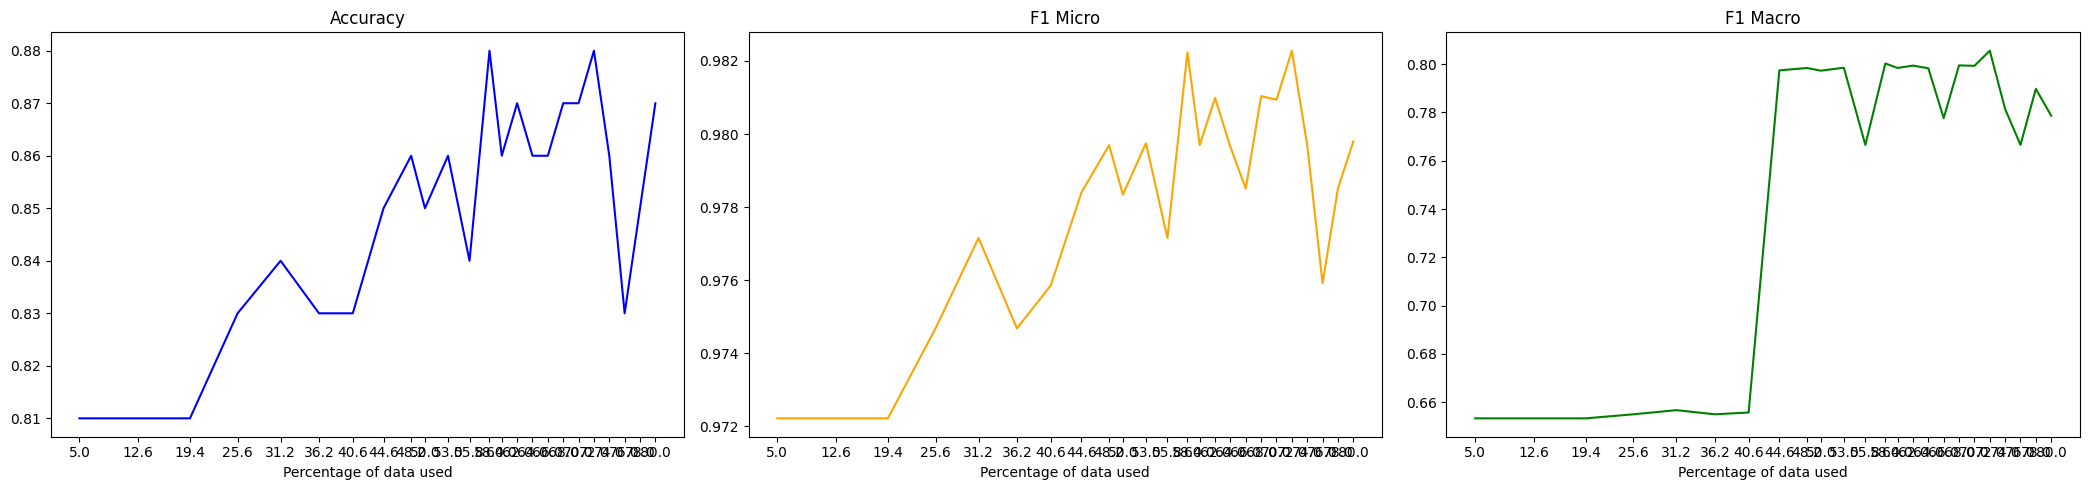

In [18]:
active_learning(seeds[2], 2)

## RUN 4

TRIAL 4
Random seed: 3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.363988,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.269921,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.219893,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.200752,0.810000,0.962500,0.982143,0.972222,0.653284
5,No log,0.187067,0.810000,0.962500,0.982143,0.972222,0.653284
6,No log,0.179119,0.810000,0.962500,0.982143,0.972222,0.653284
7,No log,0.174042,0.810000,0.962500,0.982143,0.972222,0.653284
8,No log,0.171127,0.810000,0.962500,0.982143,0.972222,0.653284
9,No log,0.169264,0.810000,0.962500,0.982143,0.972222,0.653284
10,No log,0.168764,0.810000,0.962500,0.982143,0.972222,0.653284


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.86      1.00      0.92        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.96       392
 samples avg       0.96      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 25: Accuracy: 0.81, F1 Micro: 0.9722222222222222, F1 Macro: 0.6532843428612597
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.86      1.00      0.92        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.96       392
 samples avg       0.96      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Threshold: 0.0006401465390808881
Samples above threshold: 38
Acquired samples: 38
Sampling duration: 8.452560424804688 seconds
New train size: 63


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.266662,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.189377,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.165484,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.162222,0.810000,0.962500,0.982143,0.972222,0.653284
5,No log,0.156911,0.810000,0.962500,0.982143,0.972222,0.653284
6,No log,0.155955,0.810000,0.962500,0.982143,0.972222,0.653284
7,No log,0.150712,0.810000,0.962500,0.982143,0.972222,0.653284
8,No log,0.147381,0.810000,0.962500,0.982143,0.972222,0.653284
9,No log,0.147386,0.810000,0.962500,0.982143,0.972222,0.653284
10,No log,0.147392,0.810000,0.962500,0.982143,0.972222,0.653284


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.86      1.00      0.92        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.96       392
 samples avg       0.96      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 63: Accuracy: 0.81, F1 Micro: 0.9722222222222222, F1 Macro: 0.6532843428612597
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.86      1.00      0.92        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.96       392
 samples avg       0.96      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Threshold: 0.0004152936104219407
Samples above threshold: 34
Acquired samples: 34
Sampling duration: 7.674102783203125 seconds
New train size: 97


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.206897,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.165006,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.150540,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.148724,0.810000,0.962500,0.982143,0.972222,0.653284
5,No log,0.144200,0.810000,0.962500,0.982143,0.972222,0.653284
6,No log,0.140866,0.810000,0.962500,0.982143,0.972222,0.653284
7,No log,0.138028,0.810000,0.962500,0.982143,0.972222,0.653284
8,No log,0.135705,0.810000,0.962500,0.982143,0.972222,0.653284
9,No log,0.134184,0.810000,0.962500,0.982143,0.972222,0.653284
10,No log,0.136018,0.810000,0.962500,0.982143,0.972222,0.653284


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.86      1.00      0.92        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.96       392
 samples avg       0.96      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 97: Accuracy: 0.81, F1 Micro: 0.9722222222222222, F1 Macro: 0.6532843428612597
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.86      1.00      0.92        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.96       392
 samples avg       0.96      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Threshold: 0.0002428942709229887
Samples above threshold: 31
Acquired samples: 31
Sampling duration: 6.898898601531982 seconds
New train size: 128


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.184155,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.155968,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.146209,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.141327,0.810000,0.962500,0.982143,0.972222,0.653284
5,No log,0.140836,0.810000,0.962500,0.982143,0.972222,0.653284
6,No log,0.132196,0.810000,0.962500,0.982143,0.972222,0.653284
7,No log,0.132647,0.840000,0.960494,0.992347,0.976161,0.787451
8,No log,0.124797,0.840000,0.960494,0.992347,0.976161,0.787451
9,No log,0.120734,0.840000,0.960494,0.992347,0.976161,0.787451
10,No log,0.120559,0.840000,0.960494,0.992347,0.976161,0.787451


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.67      1.00      0.80         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.87      1.00      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.99      0.98       392
   macro avg       0.75      0.83      0.79       392
weighted avg       0.96      0.99      0.97       392
 samples avg       0.96      0.99      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 128: Accuracy: 0.84, F1 Micro: 0.9761606022584692, F1 Macro: 0.7874507673502649
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.67      1.00      0.80         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.87      1.00      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.99      0.98       392
   macro avg       0.75      0.83      0.79       392
weighted avg       0.96      0.99      0.97       392
 samples avg       0.96      0.99      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Threshold: 0.0003490799164865166
Samples above threshold: 28
Acquired samples: 28
Sampling duration: 6.229615211486816 seconds
New train size: 156


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.174573,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.157913,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.147580,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.136119,0.810000,0.962500,0.982143,0.972222,0.653284
5,No log,0.124437,0.820000,0.964912,0.982143,0.973451,0.654117
6,No log,0.114970,0.860000,0.969925,0.987245,0.978508,0.766922
7,No log,0.115230,0.850000,0.969849,0.984694,0.977215,0.796716
8,No log,0.111400,0.860000,0.972362,0.987245,0.979747,0.798557
9,No log,0.111053,0.840000,0.969849,0.984694,0.977215,0.779718
10,No log,0.109851,0.860000,0.972362,0.987245,0.979747,0.798557


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.75      0.86         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      0.99      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.81      0.79      0.80       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 156: Accuracy: 0.86, F1 Micro: 0.979746835443038, F1 Macro: 0.7985573751419555
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.75      0.86         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      0.99      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.81      0.79      0.80       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Threshold: 0.00035197586403228347
Samples above threshold: 25
Acquired samples: 25
Sampling duration: 5.649824142456055 seconds
New train size: 181


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.176063,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.150378,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.155351,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.142580,0.810000,0.962500,0.982143,0.972222,0.653284
5,No log,0.122882,0.840000,0.967419,0.984694,0.975980,0.721626
6,No log,0.115677,0.820000,0.974425,0.971939,0.973180,0.762655
7,No log,0.104225,0.870000,0.974811,0.987245,0.980989,0.799427
8,No log,0.104858,0.860000,0.972362,0.987245,0.979747,0.798557
9,No log,0.102319,0.870000,0.974811,0.987245,0.980989,0.799427
10,No log,0.102072,0.870000,0.974811,0.987245,0.980989,0.799427


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.75      0.86         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.99      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.82      0.79      0.80       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 181: Accuracy: 0.87, F1 Micro: 0.9809885931558936, F1 Macro: 0.7994270293265268
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.75      0.86         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.99      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.82      0.79      0.80       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Threshold: 0.00023036787752062096
Samples above threshold: 22
Acquired samples: 22
Sampling duration: 5.144718647003174 seconds
New train size: 203


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.172294,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.151982,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.144024,0.790000,0.950980,0.989796,0.970000,0.736618
4,No log,0.119332,0.850000,0.965174,0.989796,0.977330,0.796975
5,No log,0.109660,0.860000,0.972362,0.987245,0.979747,0.798557
6,No log,0.109797,0.820000,0.965000,0.984694,0.974747,0.765704
7,No log,0.103269,0.850000,0.974684,0.982143,0.978399,0.797450
8,No log,0.109909,0.860000,0.974747,0.984694,0.979695,0.798444
9,No log,0.104974,0.850000,0.974684,0.982143,0.978399,0.797450
10,No log,0.105568,0.850000,0.974684,0.982143,0.978399,0.797450


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.75      0.86         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      0.99      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.81      0.79      0.80       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 203: Accuracy: 0.86, F1 Micro: 0.979746835443038, F1 Macro: 0.7985573751419555
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.75      0.86         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      0.99      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.81      0.79      0.80       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Threshold: 0.00019077583274338395
Samples above threshold: 20
Acquired samples: 20
Sampling duration: 4.64085578918457 seconds
New train size: 223


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.164731,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.147406,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.135277,0.820000,0.964912,0.982143,0.973451,0.654117
4,No log,0.128079,0.820000,0.972010,0.974490,0.973248,0.747810
5,No log,0.112415,0.860000,0.974747,0.984694,0.979695,0.798444
6,No log,0.110542,0.870000,0.974811,0.987245,0.980989,0.799427
7,No log,0.109411,0.850000,0.974684,0.982143,0.978399,0.797450
8,No log,0.109053,0.840000,0.974619,0.979592,0.977099,0.796445
9,No log,0.108294,0.840000,0.974619,0.979592,0.977099,0.796445
10,No log,0.109994,0.860000,0.974747,0.984694,0.979695,0.798444


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.75      0.86         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.99      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.82      0.79      0.80       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 223: Accuracy: 0.87, F1 Micro: 0.9809885931558936, F1 Macro: 0.7994270293265268
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.75      0.86         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.99      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.82      0.79      0.80       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Threshold: 0.00022412571997847423
Samples above threshold: 18
Acquired samples: 18
Sampling duration: 4.217357873916626 seconds
New train size: 241


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.160509,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.147302,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.134394,0.820000,0.964912,0.982143,0.973451,0.654117
4,No log,0.113389,0.850000,0.967500,0.987245,0.977273,0.766071
5,No log,0.112367,0.840000,0.965087,0.987245,0.976040,0.766698
6,No log,0.113120,0.840000,0.965087,0.987245,0.976040,0.766698
7,No log,0.102495,0.830000,0.974490,0.974490,0.974490,0.794401
8,No log,0.104567,0.840000,0.972152,0.979592,0.975858,0.800720
9,No log,0.108195,0.870000,0.972362,0.987245,0.979747,0.803735
10,No log,0.105129,0.850000,0.972222,0.982143,0.977157,0.801736


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.80      1.00      0.89         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.78      0.83      0.80       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 241: Accuracy: 0.87, F1 Micro: 0.979746835443038, F1 Macro: 0.8037352082157113
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.80      1.00      0.89         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.78      0.83      0.80       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Threshold: 0.0001508192042820156
Samples above threshold: 16
Acquired samples: 9
Sampling duration: 3.9198591709136963 seconds
New train size: 250


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.161385,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.139741,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.131401,0.820000,0.960199,0.984694,0.972292,0.744768
4,No log,0.111943,0.850000,0.974619,0.979592,0.977099,0.796445
5,No log,0.112768,0.840000,0.967419,0.984694,0.975980,0.775805
6,No log,0.105044,0.820000,0.972010,0.974490,0.973248,0.763530
7,No log,0.106780,0.840000,0.967419,0.984694,0.975980,0.775805
8,No log,0.110414,0.820000,0.969620,0.977041,0.973316,0.773631
9,No log,0.109062,0.850000,0.967500,0.987245,0.977273,0.776799
10,No log,0.108735,0.850000,0.969849,0.984694,0.977215,0.776683


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.57      1.00      0.73         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.74      0.83      0.78       392
weighted avg       0.96      0.99      0.97       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 250: Accuracy: 0.85, F1 Micro: 0.9772727272727273, F1 Macro: 0.7767991812796843
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.57      1.00      0.73         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.74      0.83      0.78       392
weighted avg       0.96      0.99      0.97       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 300
Threshold: 8.101805287878955e-05
Samples above threshold: 15
Acquired samples: 15
Sampling duration: 3.612694501876831 seconds
New train size: 265


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.156611,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.142908,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.134616,0.820000,0.960298,0.987245,0.973585,0.737451
4,No log,0.110275,0.860000,0.974684,0.982143,0.978399,0.797450
5,No log,0.104068,0.860000,0.974684,0.982143,0.978399,0.797450
6,No log,0.106957,0.850000,0.977041,0.977041,0.977041,0.796305
7,No log,0.110577,0.840000,0.974555,0.977041,0.975796,0.778448
8,No log,0.105175,0.850000,0.977041,0.977041,0.977041,0.796305
9,No log,0.106319,0.820000,0.969620,0.977041,0.973316,0.763683
10,No log,0.105649,0.830000,0.969697,0.979592,0.974619,0.764699


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.75      0.86         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.97      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.82      0.79      0.80       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.97      0.98      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 265: Accuracy: 0.86, F1 Micro: 0.9783989834815755, F1 Macro: 0.7974503335296063
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.75      0.86         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.97      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.82      0.79      0.80       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.97      0.98      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 300
Threshold: 0.00019557334890123464
Samples above threshold: 14
Acquired samples: 14
Sampling duration: 3.3450734615325928 seconds
New train size: 279


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.151016,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.141846,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.127656,0.840000,0.965087,0.987245,0.976040,0.750198
4,No log,0.111779,0.840000,0.969773,0.982143,0.975919,0.765704
5,No log,0.105269,0.850000,0.977041,0.977041,0.977041,0.796305
6,No log,0.116988,0.830000,0.967337,0.982143,0.974684,0.765577
7,No log,0.108545,0.830000,0.972081,0.977041,0.974555,0.764559
8,No log,0.112004,0.840000,0.974555,0.977041,0.975796,0.775413
9,No log,0.107554,0.860000,0.977099,0.979592,0.978344,0.781251
10,No log,0.110383,0.840000,0.974555,0.977041,0.975796,0.766343


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.75      0.75      0.75         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.93      0.95      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.98      0.98      0.98       392
   macro avg       0.78      0.78      0.78       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.98      0.98      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 279: Accuracy: 0.86, F1 Micro: 0.9783439490445859, F1 Macro: 0.7812506016673405
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.75      0.75      0.75         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.93      0.95      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.98      0.98      0.98       392
   macro avg       0.78      0.78      0.78       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.98      0.98      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 300
Threshold: 7.028505933703855e-05
Samples above threshold: 13
Acquired samples: 13
Sampling duration: 2.9866280555725098 seconds
New train size: 292


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.151646,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.137135,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.117524,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.101553,0.870000,0.970000,0.989796,0.979798,0.798668
5,No log,0.099472,0.840000,0.976982,0.974490,0.975734,0.795276
6,No log,0.101644,0.860000,0.970000,0.989796,0.979798,0.778661
7,No log,0.100582,0.850000,0.972222,0.982143,0.977157,0.776565
8,No log,0.102998,0.860000,0.970000,0.989796,0.979798,0.778661
9,No log,0.097142,0.870000,0.977157,0.982143,0.979644,0.781359
10,No log,0.101141,0.860000,0.972362,0.987245,0.979747,0.789799


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.75      0.86         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      1.00      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.81      0.79      0.80       392
weighted avg       0.96      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 292: Accuracy: 0.87, F1 Micro: 0.9797979797979798, F1 Macro: 0.7986680736495383
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.75      0.86         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      1.00      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.81      0.79      0.80       392
weighted avg       0.96      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 300
Threshold: 5.55659360543359e-05
Samples above threshold: 11
Acquired samples: 8
Sampling duration: 2.7129263877868652 seconds
New train size: 300


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.151731,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.143543,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.138147,0.800000,0.951100,0.992347,0.971286,0.755848
4,No log,0.105845,0.850000,0.965174,0.989796,0.977330,0.796975
5,No log,0.100656,0.850000,0.965174,0.989796,0.977330,0.776912
6,No log,0.111403,0.840000,0.962779,0.989796,0.976101,0.776052
7,No log,0.112943,0.840000,0.962779,0.989796,0.976101,0.766811
8,No log,0.101144,0.840000,0.969773,0.982143,0.975919,0.775678
9,No log,0.101647,0.860000,0.970000,0.989796,0.979798,0.778661
10,No log,0.103306,0.830000,0.969697,0.979592,0.974619,0.774660


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.57      1.00      0.73         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.99      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.75      0.83      0.78       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 300: Accuracy: 0.86, F1 Micro: 0.9797979797979798, F1 Macro: 0.778661378672608
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.57      1.00      0.73         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.99      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.75      0.83      0.78       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 350
Threshold: 2.742340384429554e-05
Samples above threshold: 10
Acquired samples: 10
Sampling duration: 2.553936243057251 seconds
New train size: 310


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.157193,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.134252,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.120181,0.840000,0.972081,0.977041,0.974555,0.720392
4,No log,0.105965,0.820000,0.967254,0.979592,0.973384,0.773784
5,No log,0.111504,0.850000,0.967581,0.989796,0.978562,0.768560
6,No log,0.104937,0.860000,0.970000,0.989796,0.979798,0.778661
7,No log,0.110688,0.840000,0.969697,0.979592,0.974619,0.775547
8,No log,0.106646,0.830000,0.967337,0.982143,0.974684,0.775678
9,No log,0.108148,0.840000,0.967500,0.987245,0.977273,0.777678
10,No log,0.106082,0.840000,0.967500,0.987245,0.977273,0.777678


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.57      1.00      0.73         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.99      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.75      0.83      0.78       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 310: Accuracy: 0.86, F1 Micro: 0.9797979797979798, F1 Macro: 0.778661378672608
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.57      1.00      0.73         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.99      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.75      0.83      0.78       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 350
Threshold: 2.4513687276339627e-05
Samples above threshold: 9
Acquired samples: 10
Sampling duration: 2.3252851963043213 seconds
New train size: 320


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.146509,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.138330,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.116927,0.830000,0.965000,0.984694,0.974747,0.710515
4,No log,0.101133,0.860000,0.974747,0.984694,0.979695,0.798444
5,No log,0.097813,0.860000,0.977099,0.979592,0.978344,0.797323
6,No log,0.098837,0.840000,0.981912,0.969388,0.975610,0.794961
7,No log,0.100850,0.850000,0.981959,0.971939,0.976923,0.796016
8,No log,0.099046,0.870000,0.974811,0.987245,0.980989,0.782449
9,No log,0.099143,0.860000,0.977099,0.979592,0.978344,0.780353
10,No log,0.100661,0.870000,0.974811,0.987245,0.980989,0.790688


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.75      0.75      0.75         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.99      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.78      0.79      0.78       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.98      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 320: Accuracy: 0.87, F1 Micro: 0.9809885931558936, F1 Macro: 0.7824492574604868
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.75      0.75      0.75         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.99      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.78      0.79      0.78       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.98      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 350
Threshold: 2.2021060976840108e-05
Samples above threshold: 8
Acquired samples: 10
Sampling duration: 2.0842037200927734 seconds
New train size: 330


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.143670,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.134666,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.117944,0.820000,0.962594,0.984694,0.973518,0.709673
4,No log,0.103179,0.850000,0.977041,0.977041,0.977041,0.796305
5,No log,0.098842,0.880000,0.977273,0.987245,0.982234,0.800306
6,No log,0.100979,0.870000,0.977157,0.982143,0.979644,0.789584
7,No log,0.101034,0.870000,0.974811,0.987245,0.980989,0.782449
8,No log,0.100395,0.860000,0.977157,0.982143,0.979644,0.781359
9,No log,0.099840,0.860000,0.977157,0.982143,0.979644,0.781359
10,No log,0.103941,0.850000,0.967581,0.989796,0.978562,0.768560


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.75      0.86         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.99      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.98      0.99      0.98       392
   macro avg       0.82      0.79      0.80       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.98      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 330: Accuracy: 0.88, F1 Micro: 0.9822335025380711, F1 Macro: 0.8003064003176297
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.75      0.86         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.99      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.98      0.99      0.98       392
   macro avg       0.82      0.79      0.80       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.98      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 350
Threshold: 3.9672742786933695e-05
Samples above threshold: 7
Acquired samples: 10
Sampling duration: 1.934657335281372 seconds
New train size: 340


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.154488,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.138374,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.119268,0.830000,0.965000,0.984694,0.974747,0.720784
4,No log,0.103895,0.830000,0.967337,0.982143,0.974684,0.729661
5,No log,0.102547,0.820000,0.974425,0.971939,0.973180,0.763374
6,No log,0.099799,0.850000,0.969849,0.984694,0.977215,0.756466
7,No log,0.103573,0.850000,0.967500,0.987245,0.977273,0.756570
8,No log,0.102198,0.850000,0.969925,0.987245,0.978508,0.757449
9,No log,0.104335,0.830000,0.969773,0.982143,0.975919,0.755471
10,No log,0.104453,0.850000,0.969925,0.987245,0.978508,0.757449


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.50      0.75      0.60         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.99      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.73      0.79      0.76       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 340: Accuracy: 0.85, F1 Micro: 0.9785082174462705, F1 Macro: 0.7574492574604869
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.50      0.75      0.60         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.99      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.73      0.79      0.76       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 350
Threshold: 1.7515433501102962e-05
Samples above threshold: 6
Acquired samples: 10
Sampling duration: 1.7206416130065918 seconds
New train size: 350


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.146662,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.134182,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.111379,0.830000,0.965000,0.984694,0.974747,0.720784
4,No log,0.111423,0.820000,0.969620,0.977041,0.973316,0.753448
5,No log,0.100323,0.830000,0.965000,0.984694,0.974747,0.746496
6,No log,0.101219,0.830000,0.969697,0.979592,0.974619,0.754466
7,No log,0.099339,0.850000,0.972292,0.984694,0.978454,0.757355
8,No log,0.103484,0.840000,0.969849,0.984694,0.977215,0.756466
9,No log,0.100983,0.840000,0.972222,0.982143,0.977157,0.756359
10,No log,0.100724,0.840000,0.972222,0.982143,0.977157,0.756359


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.50      0.75      0.60         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.92      0.98      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.74      0.79      0.76       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 350: Accuracy: 0.85, F1 Micro: 0.9784537389100126, F1 Macro: 0.7573545694574567
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.50      0.75      0.60         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.92      0.98      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.74      0.79      0.76       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 400
Threshold: 1.568895622767741e-05
Samples above threshold: 5
Acquired samples: 10
Sampling duration: 1.446030855178833 seconds
New train size: 360


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.147321,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.130509,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.115734,0.830000,0.967419,0.984694,0.975980,0.704291
4,No log,0.098501,0.860000,0.974684,0.982143,0.978399,0.751704
5,No log,0.097623,0.840000,0.974555,0.977041,0.975796,0.755232
6,No log,0.103035,0.820000,0.972010,0.974490,0.973248,0.764270
7,No log,0.099956,0.840000,0.969849,0.984694,0.977215,0.776683
8,No log,0.107416,0.830000,0.967419,0.984694,0.975980,0.766582
9,No log,0.103424,0.830000,0.967419,0.984694,0.975980,0.766582
10,No log,0.103304,0.830000,0.967419,0.984694,0.975980,0.766582


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.67      0.50      0.57         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.76      0.75      0.75       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.97      0.98      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 360: Accuracy: 0.86, F1 Micro: 0.9783989834815755, F1 Macro: 0.7517039450865887
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.67      0.50      0.57         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.76      0.75      0.75       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.97      0.98      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 400
Threshold: 5.508471003849999e-05
Samples above threshold: 4
Acquired samples: 10
Sampling duration: 1.2054328918457031 seconds
New train size: 370


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.142148,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.133307,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.115049,0.840000,0.974619,0.979592,0.977099,0.656570
4,No log,0.104228,0.810000,0.969543,0.974490,0.972010,0.744214
5,No log,0.093969,0.850000,0.981959,0.971939,0.976923,0.796016
6,No log,0.094741,0.880000,0.979695,0.984694,0.982188,0.800212
7,No log,0.098519,0.850000,0.969925,0.987245,0.978508,0.757449
8,No log,0.094452,0.840000,0.974619,0.979592,0.977099,0.756251
9,No log,0.097719,0.860000,0.972362,0.987245,0.979747,0.758339
10,No log,0.096570,0.850000,0.974684,0.982143,0.978399,0.757258


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.75      0.86         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.92      0.98      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.98      0.98      0.98       392
   macro avg       0.82      0.79      0.80       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.98      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 370: Accuracy: 0.88, F1 Micro: 0.9821882951653944, F1 Macro: 0.8002117123145996
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.75      0.86         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.92      0.98      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.98      0.98      0.98       392
   macro avg       0.82      0.79      0.80       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.98      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 400
Threshold: 1.541827150504105e-05
Samples above threshold: 3
Acquired samples: 10
Sampling duration: 0.9732155799865723 seconds
New train size: 380


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.143955,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.126929,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.104767,0.840000,0.965087,0.987245,0.976040,0.765229
4,No log,0.103025,0.840000,0.967419,0.984694,0.975980,0.766582
5,No log,0.100109,0.850000,0.969925,0.987245,0.978508,0.757449
6,No log,0.100301,0.860000,0.972292,0.984694,0.978454,0.777572
7,No log,0.112495,0.850000,0.965174,0.989796,0.977330,0.777782
8,No log,0.101210,0.860000,0.969925,0.987245,0.978508,0.777678
9,No log,0.097133,0.850000,0.974684,0.982143,0.978399,0.757258
10,No log,0.099676,0.860000,0.974747,0.984694,0.979695,0.758253


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.50      0.75      0.60         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.93      0.98      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.74      0.79      0.76       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.98      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 380: Accuracy: 0.86, F1 Micro: 0.9796954314720812, F1 Macro: 0.7582533881528857
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.50      0.75      0.60         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.93      0.98      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.74      0.79      0.76       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.98      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 400
Threshold: 6.094849732107835e-06
Samples above threshold: 2
Acquired samples: 10
Sampling duration: 0.7193441390991211 seconds
New train size: 390


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.141289,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.130431,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.109890,0.860000,0.972292,0.984694,0.978454,0.766811
4,No log,0.097061,0.840000,0.969773,0.982143,0.975919,0.765704
5,No log,0.105207,0.830000,0.965000,0.984694,0.974747,0.765704
6,No log,0.095271,0.840000,0.976982,0.974490,0.975734,0.765312
7,No log,0.097334,0.840000,0.967500,0.987245,0.977273,0.777678
8,No log,0.098956,0.850000,0.969925,0.987245,0.978508,0.778567
9,No log,0.098415,0.840000,0.972292,0.984694,0.978454,0.758253
10,No log,0.100173,0.840000,0.965087,0.987245,0.976040,0.776799


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.57      1.00      0.73         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.92      0.98      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.75      0.83      0.78       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 390: Accuracy: 0.85, F1 Micro: 0.9785082174462705, F1 Macro: 0.7785666906695781
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.57      1.00      0.73         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.92      0.98      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.75      0.83      0.78       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 400
Threshold: 1.4334290062834043e-05
Samples above threshold: 1
Acquired samples: 10
Sampling duration: 0.5034270286560059 seconds
New train size: 400


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.141415,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.131323,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.113881,0.810000,0.958025,0.989796,0.973651,0.750938
4,No log,0.102580,0.840000,0.965087,0.987245,0.976040,0.766698
5,No log,0.095565,0.830000,0.974490,0.974490,0.974490,0.774371
6,No log,0.094223,0.850000,0.967419,0.984694,0.975980,0.775805
7,No log,0.101668,0.840000,0.965087,0.987245,0.976040,0.775930
8,No log,0.103851,0.840000,0.967419,0.984694,0.975980,0.775805
9,No log,0.099545,0.850000,0.972292,0.984694,0.978454,0.777572
10,0.096500,0.103193,0.830000,0.965000,0.984694,0.974747,0.765704


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.57      1.00      0.73         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.92      0.97      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.75      0.83      0.78       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.97      0.98      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 400: Accuracy: 0.85, F1 Micro: 0.9784537389100126, F1 Macro: 0.7775715699710676
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.57      1.00      0.73         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.92      0.97      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.75      0.83      0.78       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.97      0.98      0.98       392

Total sampling time: 80.95 seconds
Total runtime: 2777.8122601509094 seconds


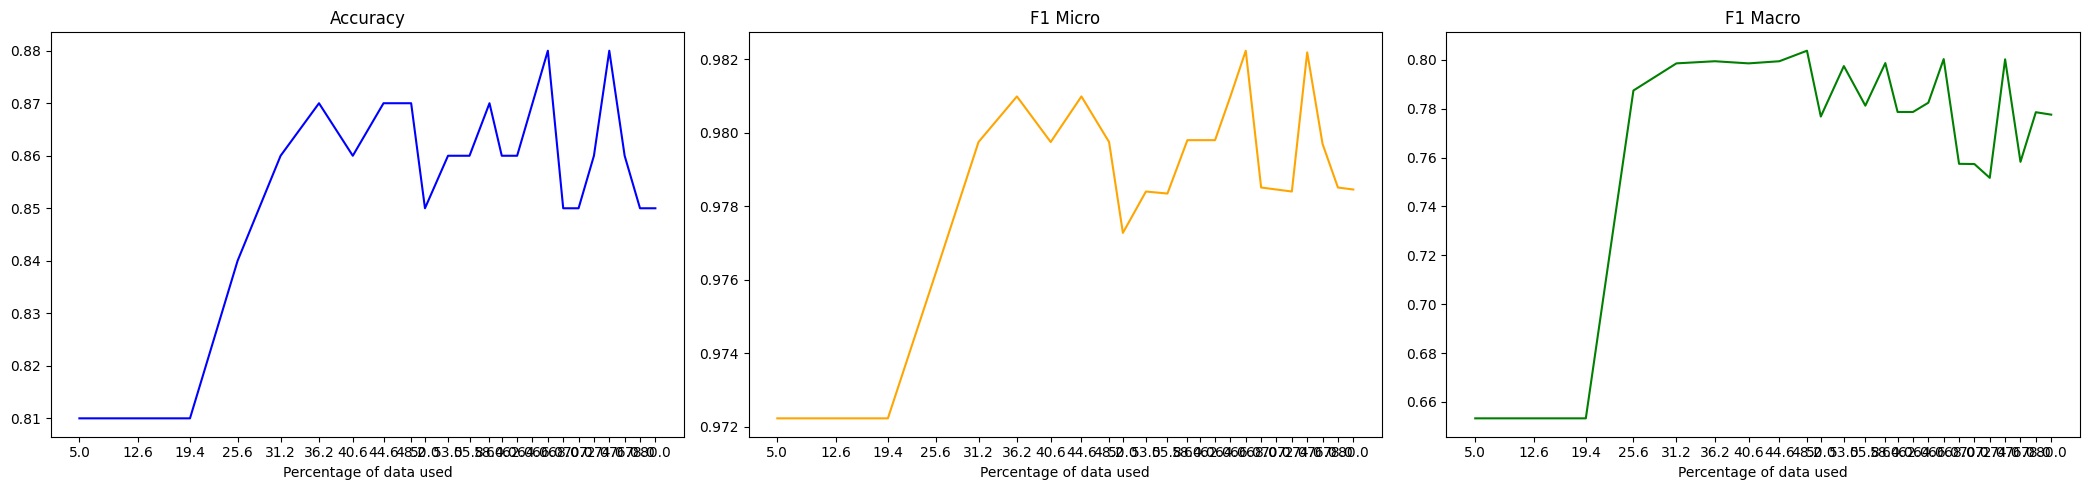

In [19]:
active_learning(seeds[3], 3)

## RUN 5

TRIAL 5
Random seed: 94


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.380765,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.275398,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.239973,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.220720,0.810000,0.962500,0.982143,0.972222,0.653284
5,No log,0.202465,0.810000,0.962500,0.982143,0.972222,0.653284
6,No log,0.190056,0.810000,0.962500,0.982143,0.972222,0.653284
7,No log,0.182793,0.810000,0.962500,0.982143,0.972222,0.653284
8,No log,0.178994,0.810000,0.962500,0.982143,0.972222,0.653284
9,No log,0.177267,0.810000,0.962500,0.982143,0.972222,0.653284
10,No log,0.177220,0.810000,0.962500,0.982143,0.972222,0.653284


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.86      1.00      0.92        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.96       392
 samples avg       0.96      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 25: Accuracy: 0.81, F1 Micro: 0.9722222222222222, F1 Macro: 0.6532843428612597
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.86      1.00      0.92        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.96       392
 samples avg       0.96      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Threshold: 0.0005662705749273301
Samples above threshold: 38
Acquired samples: 38
Sampling duration: 8.523223638534546 seconds
New train size: 63


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.286571,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.196256,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.168375,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.158261,0.810000,0.962500,0.982143,0.972222,0.653284
5,No log,0.156561,0.810000,0.962500,0.982143,0.972222,0.653284
6,No log,0.152106,0.810000,0.962500,0.982143,0.972222,0.653284
7,No log,0.149234,0.810000,0.962500,0.982143,0.972222,0.653284
8,No log,0.148194,0.810000,0.962500,0.982143,0.972222,0.653284
9,No log,0.147886,0.810000,0.962500,0.982143,0.972222,0.653284
10,No log,0.148038,0.810000,0.962500,0.982143,0.972222,0.653284


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.86      1.00      0.92        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.96       392
 samples avg       0.96      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 63: Accuracy: 0.81, F1 Micro: 0.9722222222222222, F1 Macro: 0.6532843428612597
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.86      1.00      0.92        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.96       392
 samples avg       0.96      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Threshold: 0.00042436510557308826
Samples above threshold: 34
Acquired samples: 34
Sampling duration: 7.683508396148682 seconds
New train size: 97


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.218404,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.165382,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.152626,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.146590,0.810000,0.962500,0.982143,0.972222,0.653284
5,No log,0.144517,0.810000,0.962500,0.982143,0.972222,0.653284
6,No log,0.138175,0.810000,0.962500,0.982143,0.972222,0.653284
7,No log,0.138200,0.810000,0.962500,0.982143,0.972222,0.653284
8,No log,0.133941,0.810000,0.962500,0.982143,0.972222,0.653284
9,No log,0.132782,0.810000,0.962500,0.982143,0.972222,0.653284
10,No log,0.131541,0.810000,0.962500,0.982143,0.972222,0.653284


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.86      1.00      0.92        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.96       392
 samples avg       0.96      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 97: Accuracy: 0.81, F1 Micro: 0.9722222222222222, F1 Macro: 0.6532843428612597
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.86      1.00      0.92        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.96       392
 samples avg       0.96      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Threshold: 0.0002517435495974497
Samples above threshold: 31
Acquired samples: 31
Sampling duration: 6.931101083755493 seconds
New train size: 128


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.189780,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.153169,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.143509,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.143435,0.810000,0.962500,0.982143,0.972222,0.653284
5,No log,0.134156,0.810000,0.962500,0.982143,0.972222,0.653284
6,No log,0.132250,0.810000,0.962500,0.982143,0.972222,0.653284
7,No log,0.128001,0.810000,0.962500,0.982143,0.972222,0.653284
8,No log,0.124878,0.810000,0.962500,0.982143,0.972222,0.653284
9,No log,0.121806,0.810000,0.962500,0.982143,0.972222,0.653284
10,No log,0.120678,0.810000,0.962500,0.982143,0.972222,0.653284


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.86      1.00      0.92        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.96       392
 samples avg       0.96      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 128: Accuracy: 0.81, F1 Micro: 0.9722222222222222, F1 Macro: 0.6532843428612597
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.86      1.00      0.92        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.96       392
 samples avg       0.96      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Threshold: 0.00016580059163970873
Samples above threshold: 28
Acquired samples: 28
Sampling duration: 6.240065574645996 seconds
New train size: 156


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.173648,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.146800,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.141586,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.133650,0.810000,0.962500,0.982143,0.972222,0.653284
5,No log,0.139534,0.810000,0.962500,0.982143,0.972222,0.653284
6,No log,0.122372,0.820000,0.964912,0.982143,0.973451,0.654117
7,No log,0.118637,0.820000,0.967254,0.979592,0.973384,0.653989
8,No log,0.120005,0.820000,0.974425,0.971939,0.973180,0.653588
9,No log,0.119497,0.840000,0.972081,0.977041,0.974555,0.654718
10,No log,0.117266,0.830000,0.974490,0.974490,0.974490,0.654593


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      0.98      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.97       392
   macro avg       0.65      0.66      0.65       392
weighted avg       0.96      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 156: Accuracy: 0.84, F1 Micro: 0.9745547073791349, F1 Macro: 0.6547180346175321
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      0.98      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.97       392
   macro avg       0.65      0.66      0.65       392
weighted avg       0.96      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Threshold: 0.0002193956810515375
Samples above threshold: 25
Acquired samples: 25
Sampling duration: 5.689047813415527 seconds
New train size: 181


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.164349,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.142059,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.135196,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.135974,0.830000,0.972081,0.977041,0.974555,0.654718
5,No log,0.121805,0.830000,0.974490,0.974490,0.974490,0.654593
6,No log,0.121451,0.830000,0.972081,0.977041,0.974555,0.654718
7,No log,0.114885,0.820000,0.979328,0.966837,0.973042,0.653305
8,No log,0.115373,0.810000,0.979275,0.964286,0.971722,0.652263
9,No log,0.113932,0.830000,0.979381,0.969388,0.974359,0.719972
10,No log,0.113942,0.830000,0.979381,0.969388,0.974359,0.719972


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      0.98      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.97       392
   macro avg       0.65      0.66      0.65       392
weighted avg       0.96      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 181: Accuracy: 0.83, F1 Micro: 0.9745547073791349, F1 Macro: 0.6547180346175321
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      0.98      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.97       392
   macro avg       0.65      0.66      0.65       392
weighted avg       0.96      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Threshold: 0.00016083536611404272
Samples above threshold: 22
Acquired samples: 22
Sampling duration: 5.1188671588897705 seconds
New train size: 203


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.160446,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.140731,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.135513,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.121592,0.810000,0.964824,0.979592,0.972152,0.653148
5,No log,0.129560,0.830000,0.969697,0.979592,0.974619,0.654840
6,No log,0.114511,0.850000,0.977041,0.977041,0.977041,0.656466
7,No log,0.115677,0.770000,0.976562,0.956633,0.966495,0.648182
8,No log,0.111273,0.820000,0.976864,0.969388,0.973111,0.653448
9,No log,0.111531,0.850000,0.977041,0.977041,0.977041,0.722138
10,No log,0.111176,0.850000,0.977041,0.977041,0.977041,0.722138


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.98      0.98      0.98       392
   macro avg       0.65      0.66      0.66       392
weighted avg       0.96      0.98      0.97       392
 samples avg       0.98      0.98      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 203: Accuracy: 0.85, F1 Micro: 0.9770408163265306, F1 Macro: 0.6564658498484934
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.98      0.98      0.98       392
   macro avg       0.65      0.66      0.66       392
weighted avg       0.96      0.98      0.97       392
 samples avg       0.98      0.98      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Threshold: 0.00010903634829446674
Samples above threshold: 20
Acquired samples: 20
Sampling duration: 4.680246114730835 seconds
New train size: 223


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.158331,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.141223,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.130240,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.132453,0.830000,0.967337,0.982143,0.974684,0.654960
5,No log,0.123359,0.830000,0.979381,0.969388,0.974359,0.654335
6,No log,0.114254,0.840000,0.979434,0.971939,0.975672,0.655353
7,No log,0.111928,0.830000,0.976923,0.971939,0.974425,0.654466
8,No log,0.113088,0.850000,0.974619,0.979592,0.977099,0.779466
9,No log,0.111380,0.850000,0.974619,0.979592,0.977099,0.779466
10,No log,0.110091,0.850000,0.974619,0.979592,0.977099,0.779466


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.75      0.75      0.75         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.95      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.78      0.78      0.78       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.97      0.98      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 223: Accuracy: 0.85, F1 Micro: 0.9770992366412214, F1 Macro: 0.7794655093650068
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.75      0.75      0.75         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.95      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.78      0.78      0.78       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.97      0.98      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Threshold: 0.000250016525387764
Samples above threshold: 18
Acquired samples: 18
Sampling duration: 4.205075025558472 seconds
New train size: 241


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.154692,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.140837,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.127906,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.120972,0.830000,0.974490,0.974490,0.974490,0.654593
5,No log,0.110174,0.840000,0.974555,0.977041,0.975796,0.749704
6,No log,0.107833,0.840000,0.972152,0.979592,0.975858,0.775547
7,No log,0.107900,0.840000,0.967500,0.987245,0.977273,0.756570
8,No log,0.102232,0.860000,0.974747,0.984694,0.979695,0.781466
9,No log,0.103873,0.840000,0.967500,0.987245,0.977273,0.767577
10,No log,0.102341,0.850000,0.972292,0.984694,0.978454,0.767577


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.75      0.75      0.75         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.78      0.79      0.78       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.98      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 241: Accuracy: 0.86, F1 Micro: 0.9796954314720812, F1 Macro: 0.7814658498484933
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.75      0.75      0.75         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.78      0.79      0.78       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.98      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Threshold: 6.125776271801442e-05
Samples above threshold: 16
Acquired samples: 9
Sampling duration: 3.835616111755371 seconds
New train size: 250


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.149825,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.144017,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.134737,0.820000,0.974425,0.971939,0.973180,0.653588
4,No log,0.115998,0.840000,0.976982,0.974490,0.975734,0.655471
5,No log,0.114407,0.850000,0.972222,0.982143,0.977157,0.766582
6,No log,0.114370,0.850000,0.972222,0.982143,0.977157,0.766582
7,No log,0.108916,0.780000,0.964557,0.971939,0.968234,0.734712
8,No log,0.105963,0.850000,0.977041,0.977041,0.977041,0.796305
9,No log,0.102443,0.860000,0.977099,0.979592,0.978344,0.797323
10,No log,0.102781,0.860000,0.977099,0.979592,0.978344,0.797323


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.75      0.86         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.95      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.98      0.98      0.98       392
   macro avg       0.82      0.78      0.80       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.98      0.98      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 250: Accuracy: 0.86, F1 Micro: 0.9783439490445859, F1 Macro: 0.7973226522221498
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.75      0.86         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.95      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.98      0.98      0.98       392
   macro avg       0.82      0.78      0.80       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.98      0.98      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 300
Threshold: 4.5683857388212324e-05
Samples above threshold: 15
Acquired samples: 15
Sampling duration: 3.6899986267089844 seconds
New train size: 265


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.159351,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.140173,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.130134,0.840000,0.974555,0.977041,0.975796,0.655587
4,No log,0.114438,0.840000,0.967419,0.984694,0.975980,0.766582
5,No log,0.108622,0.820000,0.967254,0.979592,0.973384,0.764559
6,No log,0.119257,0.800000,0.964736,0.977041,0.970849,0.754983
7,No log,0.105912,0.870000,0.972431,0.989796,0.981037,0.790783
8,No log,0.102669,0.860000,0.970000,0.989796,0.979798,0.778661
9,No log,0.108997,0.860000,0.970000,0.989796,0.979798,0.778661
10,No log,0.104407,0.850000,0.969925,0.987245,0.978508,0.777678


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.67      1.00      0.80         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.99      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.76      0.83      0.79       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 265: Accuracy: 0.87, F1 Micro: 0.9810366624525917, F1 Macro: 0.7907825907938201
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.67      1.00      0.80         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.99      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.76      0.83      0.79       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 300
Threshold: 5.496216035680848e-05
Samples above threshold: 14
Acquired samples: 14
Sampling duration: 3.357755422592163 seconds
New train size: 279


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.146857,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.141419,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.135432,0.830000,0.972081,0.977041,0.974555,0.654718
4,No log,0.115012,0.840000,0.969849,0.984694,0.977215,0.750938
5,No log,0.106229,0.830000,0.967419,0.984694,0.975980,0.739034
6,No log,0.101607,0.840000,0.974555,0.977041,0.975796,0.765446
7,No log,0.097517,0.860000,0.972292,0.984694,0.978454,0.767577
8,No log,0.101514,0.830000,0.967337,0.982143,0.974684,0.765577
9,No log,0.100390,0.840000,0.969773,0.982143,0.975919,0.775678
10,No log,0.101342,0.850000,0.969849,0.984694,0.977215,0.776683


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.60      0.75      0.67         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.75      0.79      0.77       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.97      0.98      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 279: Accuracy: 0.86, F1 Micro: 0.9784537389100126, F1 Macro: 0.7675769609596045
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.60      0.75      0.67         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.75      0.79      0.77       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.97      0.98      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 300
Threshold: 3.889627623721026e-05
Samples above threshold: 13
Acquired samples: 13
Sampling duration: 3.068183183670044 seconds
New train size: 292


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.149870,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.139689,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.125177,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.110446,0.860000,0.974747,0.984694,0.979695,0.752687
5,No log,0.099034,0.870000,0.977157,0.982143,0.979644,0.798328
6,No log,0.100050,0.880000,0.974811,0.987245,0.980989,0.799427
7,No log,0.106026,0.790000,0.964646,0.974490,0.969543,0.753942
8,No log,0.100924,0.840000,0.967419,0.984694,0.975980,0.755587
9,No log,0.102054,0.850000,0.967500,0.987245,0.977273,0.776799
10,No log,0.103435,0.840000,0.965087,0.987245,0.976040,0.766698


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.75      0.86         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.99      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.82      0.79      0.80       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 292: Accuracy: 0.88, F1 Micro: 0.9809885931558936, F1 Macro: 0.7994270293265268
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.75      0.86         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.99      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.82      0.79      0.80       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 300
Threshold: 2.597882012196351e-05
Samples above threshold: 11
Acquired samples: 8
Sampling duration: 2.7555441856384277 seconds
New train size: 300


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.142625,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.137411,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.119479,0.830000,0.967337,0.982143,0.974684,0.654960
4,No log,0.110296,0.840000,0.965087,0.987245,0.976040,0.724209
5,No log,0.117474,0.860000,0.965261,0.992347,0.978616,0.768653
6,No log,0.104254,0.860000,0.970000,0.989796,0.979798,0.778661
7,No log,0.099167,0.850000,0.974619,0.979592,0.977099,0.779466
8,No log,0.102313,0.850000,0.969849,0.984694,0.977215,0.776683
9,No log,0.104746,0.850000,0.969849,0.984694,0.977215,0.776683
10,No log,0.102654,0.850000,0.969849,0.984694,0.977215,0.776683


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.57      1.00      0.73         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.99      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.75      0.83      0.78       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 300: Accuracy: 0.86, F1 Micro: 0.9797979797979798, F1 Macro: 0.778661378672608
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.57      1.00      0.73         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.99      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.75      0.83      0.78       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 350
Threshold: 2.788163492368768e-05
Samples above threshold: 10
Acquired samples: 10
Sampling duration: 2.609494686126709 seconds
New train size: 310


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.153455,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.134221,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.127238,0.850000,0.974619,0.979592,0.977099,0.656570
4,No log,0.128856,0.840000,0.969773,0.982143,0.975919,0.738920
5,No log,0.112296,0.810000,0.979275,0.964286,0.971722,0.774956
6,No log,0.102401,0.850000,0.969849,0.984694,0.977215,0.776683
7,No log,0.099911,0.850000,0.969925,0.987245,0.978508,0.757449
8,No log,0.100029,0.840000,0.969773,0.982143,0.975919,0.755471
9,No log,0.102372,0.860000,0.969925,0.987245,0.978508,0.777678
10,No log,0.098872,0.840000,0.969773,0.982143,0.975919,0.755471


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.50      0.75      0.60         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.99      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.73      0.79      0.76       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 310: Accuracy: 0.85, F1 Micro: 0.9785082174462705, F1 Macro: 0.7574492574604869
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.50      0.75      0.60         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.99      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.73      0.79      0.76       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 350
Threshold: 2.700167588045588e-05
Samples above threshold: 9
Acquired samples: 10
Sampling duration: 2.3815629482269287 seconds
New train size: 320


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.145394,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.139471,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.118314,0.830000,0.974490,0.974490,0.974490,0.654593
4,No log,0.115738,0.830000,0.965087,0.987245,0.976040,0.747479
5,No log,0.107158,0.870000,0.974811,0.987245,0.980989,0.782449
6,No log,0.096991,0.880000,0.977273,0.987245,0.982234,0.800306
7,No log,0.101670,0.870000,0.974811,0.987245,0.980989,0.782449
8,No log,0.106360,0.850000,0.967581,0.989796,0.978562,0.768560
9,No log,0.098986,0.850000,0.969925,0.987245,0.978508,0.777678
10,No log,0.099487,0.850000,0.969925,0.987245,0.978508,0.777678


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.75      0.86         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.99      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.98      0.99      0.98       392
   macro avg       0.82      0.79      0.80       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.98      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 320: Accuracy: 0.88, F1 Micro: 0.9822335025380711, F1 Macro: 0.8003064003176297
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.75      0.86         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.99      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.98      0.99      0.98       392
   macro avg       0.82      0.79      0.80       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.98      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 350
Threshold: 2.0621707517420876e-05
Samples above threshold: 8
Acquired samples: 10
Sampling duration: 2.1348795890808105 seconds
New train size: 330


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.143429,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.130012,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.116180,0.820000,0.969697,0.979592,0.974619,0.654840
4,No log,0.104384,0.850000,0.977041,0.977041,0.977041,0.765577
5,No log,0.120586,0.830000,0.962687,0.987245,0.974811,0.751704
6,No log,0.103532,0.840000,0.969773,0.982143,0.975919,0.766464
7,No log,0.099862,0.860000,0.972292,0.984694,0.978454,0.788805
8,No log,0.109531,0.830000,0.965000,0.984694,0.974747,0.758035
9,No log,0.109219,0.840000,0.967500,0.987245,0.977273,0.759919
10,No log,0.103972,0.850000,0.969849,0.984694,0.977215,0.767471


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.67      1.00      0.80         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.97      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.76      0.83      0.79       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.97      0.98      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 330: Accuracy: 0.86, F1 Micro: 0.9784537389100126, F1 Macro: 0.7888046636194153
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.67      1.00      0.80         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.97      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.76      0.83      0.79       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.97      0.98      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 350
Threshold: 2.296981219842565e-05
Samples above threshold: 7
Acquired samples: 10
Sampling duration: 1.9159975051879883 seconds
New train size: 340


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.143500,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.133300,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.122399,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.102399,0.850000,0.972292,0.984694,0.978454,0.751808
5,No log,0.110943,0.840000,0.965087,0.987245,0.976040,0.766698
6,No log,0.096379,0.840000,0.972152,0.979592,0.975858,0.738805
7,No log,0.102818,0.840000,0.967419,0.984694,0.975980,0.730644
8,No log,0.099927,0.840000,0.969849,0.984694,0.977215,0.756466
9,No log,0.106571,0.850000,0.969925,0.987245,0.978508,0.777678
10,No log,0.102103,0.830000,0.969773,0.982143,0.975919,0.755471


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.57      1.00      0.73         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.75      0.83      0.78       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 340: Accuracy: 0.85, F1 Micro: 0.9785082174462705, F1 Macro: 0.7776779710606146
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.57      1.00      0.73         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.75      0.83      0.78       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 350
Threshold: 1.4121381627774101e-05
Samples above threshold: 6
Acquired samples: 10
Sampling duration: 1.7259297370910645 seconds
New train size: 350


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.140964,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.131915,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.116531,0.850000,0.974684,0.982143,0.978399,0.657542
4,No log,0.103994,0.830000,0.969697,0.979592,0.974619,0.729545
5,No log,0.098208,0.870000,0.977215,0.984694,0.980940,0.768560
6,No log,0.101796,0.850000,0.969849,0.984694,0.977215,0.776683
7,No log,0.107135,0.840000,0.965174,0.989796,0.977330,0.767681
8,No log,0.104872,0.850000,0.967581,0.989796,0.978562,0.768560
9,No log,0.102427,0.860000,0.970000,0.989796,0.979798,0.778661
10,No log,0.103058,0.860000,0.970000,0.989796,0.979798,0.778661


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.50      0.67         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.99      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.98      0.98      0.98       392
   macro avg       0.82      0.75      0.77       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.98      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 350: Accuracy: 0.87, F1 Micro: 0.9809402795425667, F1 Macro: 0.7685603685715979
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.50      0.67         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.99      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.98      0.98      0.98       392
   macro avg       0.82      0.75      0.77       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.98      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 400
Threshold: 1.7726403712003957e-05
Samples above threshold: 5
Acquired samples: 10
Sampling duration: 1.465447187423706 seconds
New train size: 360


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.143841,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.130751,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.115783,0.840000,0.974619,0.979592,0.977099,0.656570
4,No log,0.100375,0.830000,0.965000,0.984694,0.974747,0.738173
5,No log,0.110672,0.840000,0.962779,0.989796,0.976101,0.759134
6,No log,0.104377,0.820000,0.964912,0.982143,0.973451,0.757030
7,No log,0.099874,0.840000,0.967419,0.984694,0.975980,0.766582
8,No log,0.101383,0.850000,0.967581,0.989796,0.978562,0.768560
9,No log,0.097220,0.850000,0.967581,0.989796,0.978562,0.768560
10,No log,0.100139,0.850000,0.967581,0.989796,0.978562,0.768560


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.50      1.00      0.67         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.99      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.73      0.83      0.77       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 360: Accuracy: 0.85, F1 Micro: 0.978562421185372, F1 Macro: 0.7685603685715979
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.50      1.00      0.67         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.99      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.73      0.83      0.77       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 400
Threshold: 1.8019488925347106e-05
Samples above threshold: 4
Acquired samples: 10
Sampling duration: 1.2437388896942139 seconds
New train size: 370


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.139734,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.129303,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.109600,0.840000,0.969773,0.982143,0.975919,0.655811
4,No log,0.107046,0.830000,0.965087,0.987245,0.976040,0.759030
5,No log,0.094396,0.850000,0.972292,0.984694,0.978454,0.777572
6,No log,0.090381,0.850000,0.977099,0.979592,0.978344,0.780353
7,No log,0.095609,0.860000,0.972362,0.987245,0.979747,0.758339
8,No log,0.095406,0.850000,0.969925,0.987245,0.978508,0.757449
9,No log,0.094512,0.870000,0.972431,0.989796,0.981037,0.779551
10,No log,0.093967,0.870000,0.972431,0.989796,0.981037,0.779551


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.57      1.00      0.73         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.92      0.99      0.96        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.75      0.83      0.78       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 370: Accuracy: 0.87, F1 Micro: 0.9810366624525917, F1 Macro: 0.7795506302366446
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.57      1.00      0.73         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.92      0.99      0.96        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.75      0.83      0.78       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 400
Threshold: 8.760284345044058e-06
Samples above threshold: 3
Acquired samples: 10
Sampling duration: 1.062861442565918 seconds
New train size: 380


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.141126,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.131404,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.112061,0.830000,0.967337,0.982143,0.974684,0.654960
4,No log,0.105104,0.830000,0.965087,0.987245,0.976040,0.739144
5,No log,0.104453,0.830000,0.972081,0.977041,0.974555,0.765312
6,No log,0.104454,0.840000,0.965174,0.989796,0.977330,0.760013
7,No log,0.092873,0.820000,0.969620,0.977041,0.973316,0.753448
8,No log,0.096921,0.850000,0.969925,0.987245,0.978508,0.757449
9,No log,0.092995,0.830000,0.967419,0.984694,0.975980,0.747375
10,No log,0.093362,0.830000,0.967419,0.984694,0.975980,0.747375


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.50      0.75      0.60         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.99      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.73      0.79      0.76       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 380: Accuracy: 0.85, F1 Micro: 0.9785082174462705, F1 Macro: 0.7574492574604869
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.50      0.75      0.60         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.99      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.73      0.79      0.76       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 400
Threshold: 5.926881385676097e-06
Samples above threshold: 2
Acquired samples: 10
Sampling duration: 0.7369823455810547 seconds
New train size: 390


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.139245,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.136661,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.118725,0.830000,0.967337,0.982143,0.974684,0.654960
4,No log,0.116285,0.800000,0.957921,0.987245,0.972362,0.744476
5,No log,0.099261,0.830000,0.967337,0.982143,0.974684,0.765577
6,No log,0.103126,0.830000,0.965000,0.984694,0.974747,0.758035
7,No log,0.101714,0.840000,0.967500,0.987245,0.977273,0.767577
8,No log,0.103971,0.850000,0.969925,0.987245,0.978508,0.768466
9,No log,0.097124,0.850000,0.969925,0.987245,0.978508,0.777678
10,No log,0.099039,0.850000,0.969925,0.987245,0.978508,0.777678


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.50      1.00      0.67         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.92      0.98      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.74      0.83      0.77       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 390: Accuracy: 0.85, F1 Micro: 0.9785082174462705, F1 Macro: 0.7684656805685678
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.50      1.00      0.67         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.92      0.98      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.74      0.83      0.77       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 400
Threshold: 5.085808925286981e-06
Samples above threshold: 1
Acquired samples: 10
Sampling duration: 0.5289406776428223 seconds
New train size: 400


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.135887,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.121588,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.111039,0.830000,0.972152,0.979592,0.975858,0.655700
4,No log,0.100169,0.840000,0.967419,0.984694,0.975980,0.755587
5,No log,0.095688,0.880000,0.977215,0.984694,0.980940,0.799323
6,No log,0.092839,0.870000,0.979644,0.982143,0.980892,0.799217
7,No log,0.099582,0.840000,0.972222,0.982143,0.977157,0.756359
8,No log,0.098824,0.860000,0.972362,0.987245,0.979747,0.768560
9,No log,0.098060,0.830000,0.969773,0.982143,0.975919,0.755471
10,0.095100,0.096787,0.830000,0.969773,0.982143,0.975919,0.755471


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.75      0.86         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.98      0.98      0.98       392
   macro avg       0.82      0.79      0.80       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.98      0.98      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 400: Accuracy: 0.88, F1 Micro: 0.9809402795425667, F1 Macro: 0.7993229927056363
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.75      0.86         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.98      0.98      0.98       392
   macro avg       0.82      0.79      0.80       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.98      0.98      0.98       392

Total sampling time: 81.58 seconds
Total runtime: 2742.515187740326 seconds


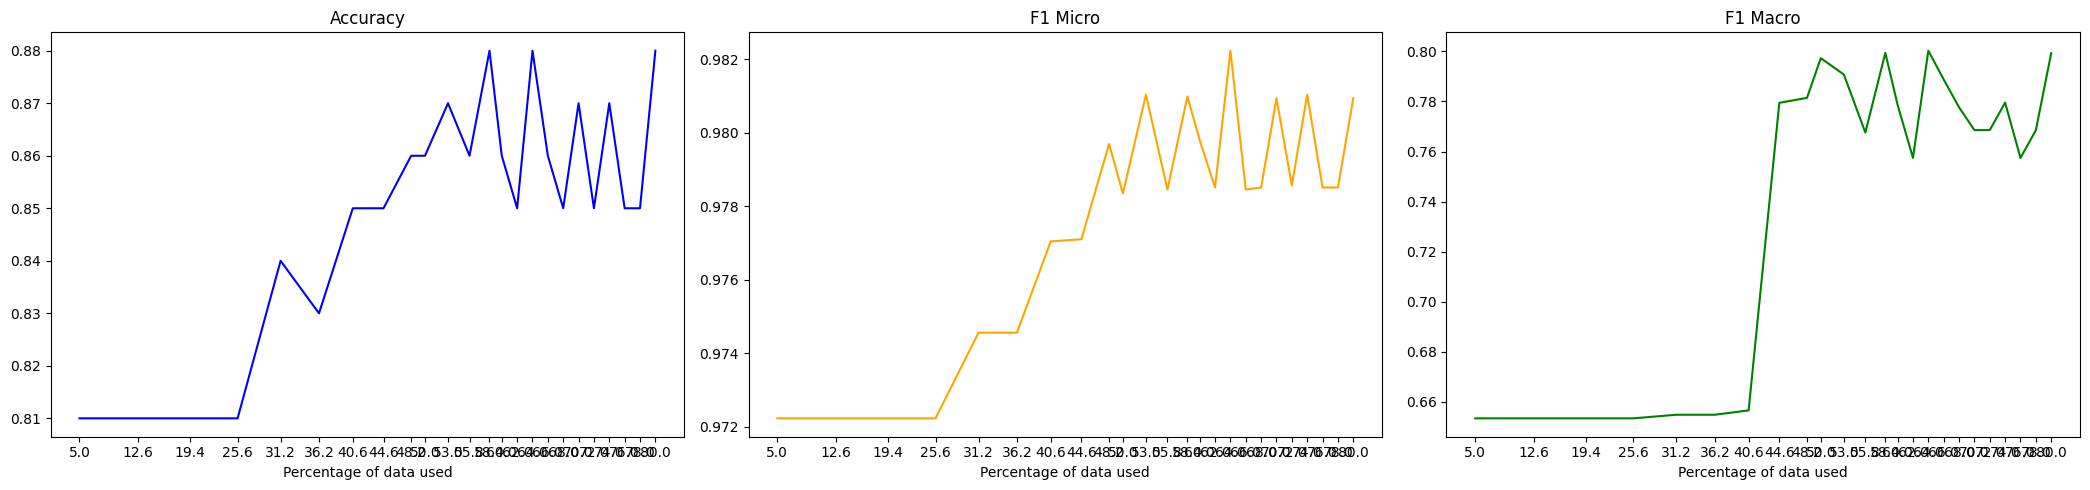

In [20]:
active_learning(seeds[4], 4)